In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the following paths/configs accordingly; for `pythonpath` on molgpu, you can either
1) set up your own ms-gen environment from source
2) use Mrunali's pre-built environment, after telling conda to look in my folder with `conda config --add envs_dirs /home/mrunali/miniconda3/envs`
3) Clone Mrunali's pre-built environment into your own environment with `conda --clone` and then source that instead.

In [3]:
config = dict(
    python_path='/home/roger/miniforge3/envs/ms-main/bin/python',
    gen_ckpt='/home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt',
    inten_ckpt='/home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt',
    cuda_devices=0,
    batch_size=8,
    num_workers=6,
    sparse_k=100,
    max_nodes=100,
    threshold=0.0,
    binned_out=False,
    ppm=20,
    num_bins=15000,
    dist_func='entropy'
)

The following cell enables SA score. See instructions in [the rdkik blog](https://greglandrum.github.io/rdkit-blog/posts/2023-12-01-using_sascore_and_npscore.html)
You can safely skip it if you are not setting ``sa_score=True`` in function ``plot_top_mols``

In [4]:
# sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
sys.path.append(os.path.join('/home/roger/miniforge3/envs/ms-main','share','RDKit','Contrib'))
from SA_Score import sascorer

# Elucidation on Broad data

In [16]:
def broad_elucidation(spec_file, formula, real_smi=None, name="", vis_peaks=False, buyable_report=False, **kwargs):
    broad_config = copy.deepcopy(config)
    broad_config['nce'] = True # use nce for collision energy
    broad_config['merge_spec'] = True # merge spec for visualization
    for k, v in kwargs.items():
        broad_config[k] = v
    exp_spec_path = f'/home/roger/ms_collaborators/broad-Julian/spec_files/{spec_file}.ms'

    # Get candidates
    smiles = candidates_from_pubchem(formula)

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], **broad_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, mol_name=name, real_smiles=real_smi, **broad_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if vis_peaks:
        explain_peaks(result_path, exp_spec_path, pmz, real_smi, num_peaks=10, save_path='gaba_arg.pdf', **broad_config)

    # Buyable report
    if buyable_report:
        generate_buyable_report(
            [spec_file], # names
            [exp_spec_path], #exp_specs
            [{'[M+H]+': smiles}], # adduct_to_smiles
            broad_config,
            [10, 20, 30, 40, 50], topk_per_row=10, output_name=f'broad_{spec_file}_buyable_report')

    return img


## GABA-Arg isomers

[GABA-Arg] Found target mol at 1/60, ent_dist=0.434


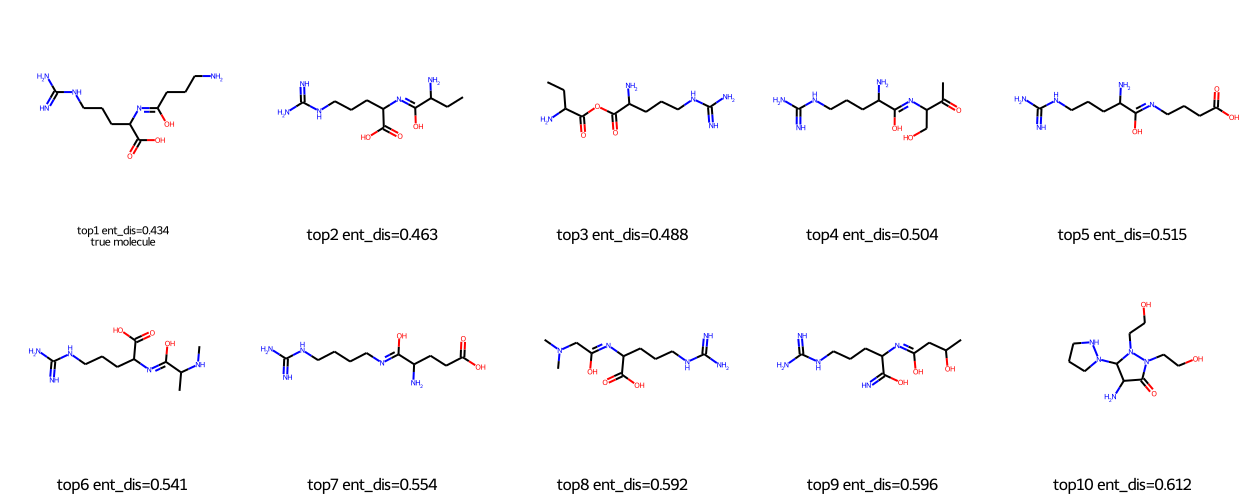

In [6]:
broad_elucidation('mxp4308', 'C10H21N5O3', r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N', 'GABA-Arg', False)

In [ ]:
broad_elucidation('mxp4309', 'C10H21N5O3', r'O=C(NCCCC(O)=O)C(N)CCC/N=C(N)\N', 'Arg-GABA')

In [ ]:
broad_elucidation('mxp4155', 'C10H21N5O3', r'C[C@@H](C(=O)N[C@@H](CCCCN=C(N)N)C(=O)O)N', 'Alanylhomoaruginine')

In [ ]:
broad_elucidation('mxp4156', 'C10H21N5O3', r'N/C(N)=N\CCCC(C(O)=O)NC(C(N)CC)=O', '2-(2-aminobutanamido)-5- [(diaminomethylidene)amino]pentanoic acid')

In [ ]:
broad_elucidation('mxp4157', 'C10H21N5O3', r'O=C(O)C(N)CCCNC(CCC/N=C(N)\N)=O', '2-amino-5-{4 [(diaminomethylidene)amino]butanamido}pentanoic acid')

## OH-Tryptopha elucidation

[4-Hydroxy Tryptophan] Found target mol at 3/7409, ent_dist=0.186


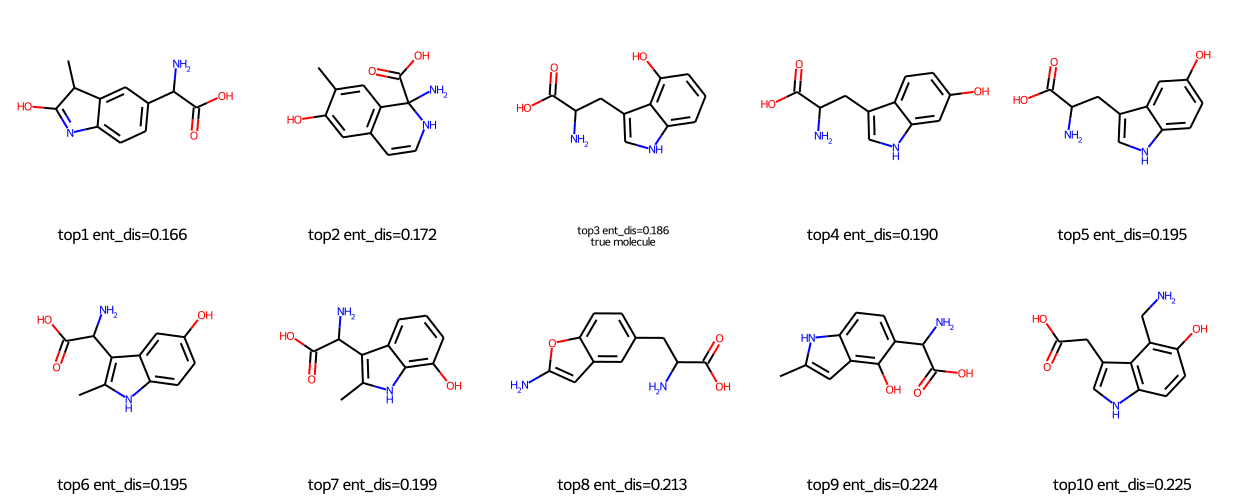

In [18]:
broad_elucidation('mxp4310', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)C(=CN2)CC(C(=O)O)N', '4-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp0141', 'C11H12N2O3', 'C1=CC2=C(C=C1O)C(=CN2)C[C@@H](C(=O)O)N', '5-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp4412', 'C11H12N2O3', 'C1=CC2=C(C(=C1)O)NC=C2CC(C(=O)O)N', '7-Hydroxy Tryptophan')

In [ ]:
broad_elucidation('mxp4411', 'C11H12N2O3', 'C1=CC2=C(C=C1O)NC=C2C[C@@H](C(=O)O)N', '6-Hydroxy Tryptophan')

Found target mol at 1297/7409, ent_dist=0.863


msg from process_response(): status_code 401 reason Unauthorized


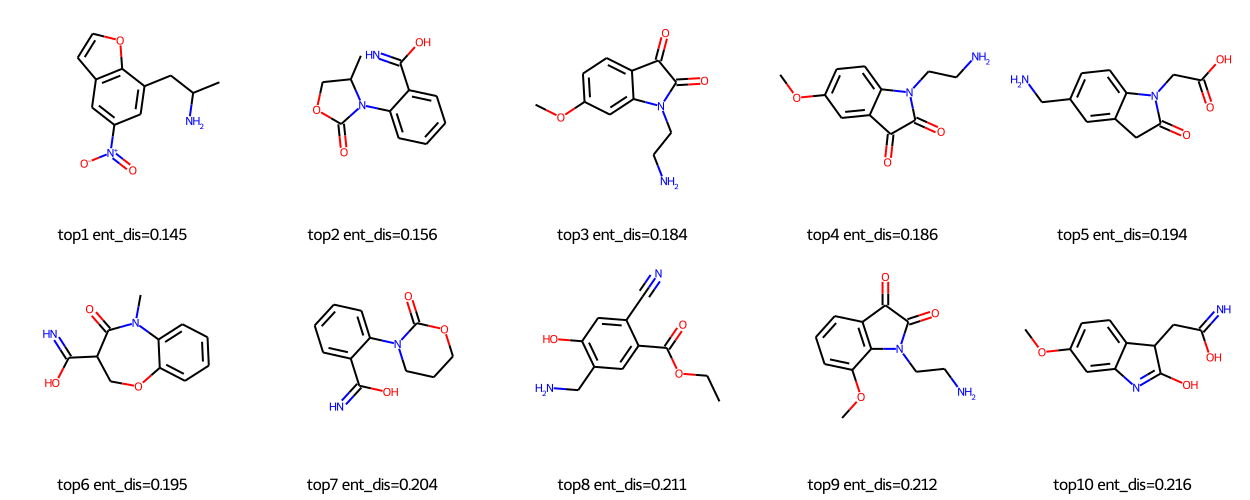

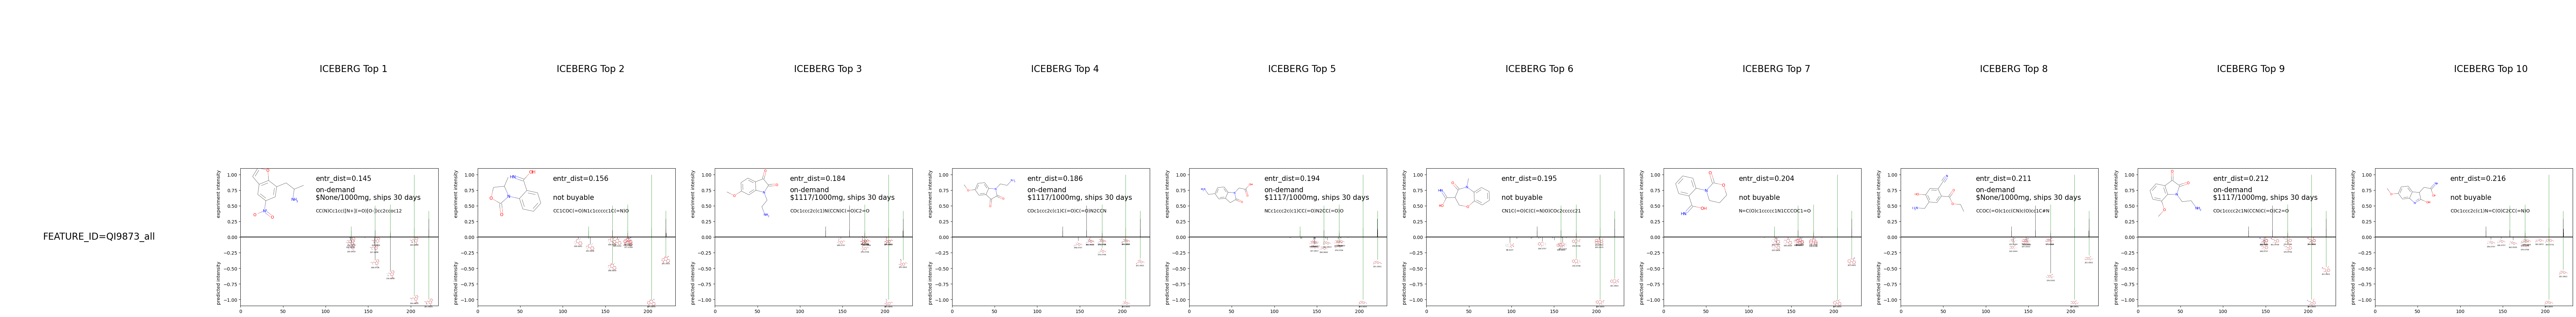

In [17]:
broad_elucidation('QI9873_all', 'C11H12N2O3', 'C1=CC2=C(C=C1)NC=C2C(O)[C@@H](C(=O)O)N', buyable_report=True)

### Modifinder

The following collision energies pairs are matched between two spectra:
[('12', '13'), ('16', '17'), ('20', '22'), ('4', '4'), ('8', '8')]
Covered peak: 204.06550, 1.00
Covered peak: 162.05500, 0.42
Covered peak: 221.09220, 0.34
Covered peak: 175.08660, 0.33
Covered peak: 160.07580, 0.28
Covered peak: 148.07590, 0.15
Covered peak: 204.06560, 1.00
Covered peak: 162.05490, 0.88
Covered peak: 186.05490, 0.74
Covered peak: 160.07570, 0.59
Covered peak: 175.08660, 0.57
Covered peak: 148.07580, 0.25
Covered peak: 162.05500, 1.00
Covered peak: 186.05490, 0.82
Covered peak: 160.07580, 0.63
Covered peak: 204.06560, 0.52
Covered peak: 175.08660, 0.50
Covered peak: 148.07580, 0.46
Covered peak: 221.09210, 1.00
Covered peak: 204.06550, 0.44
Covered peak: 204.06550, 1.00
Covered peak: 221.09220, 0.77
Covered peak: 175.08680, 0.19


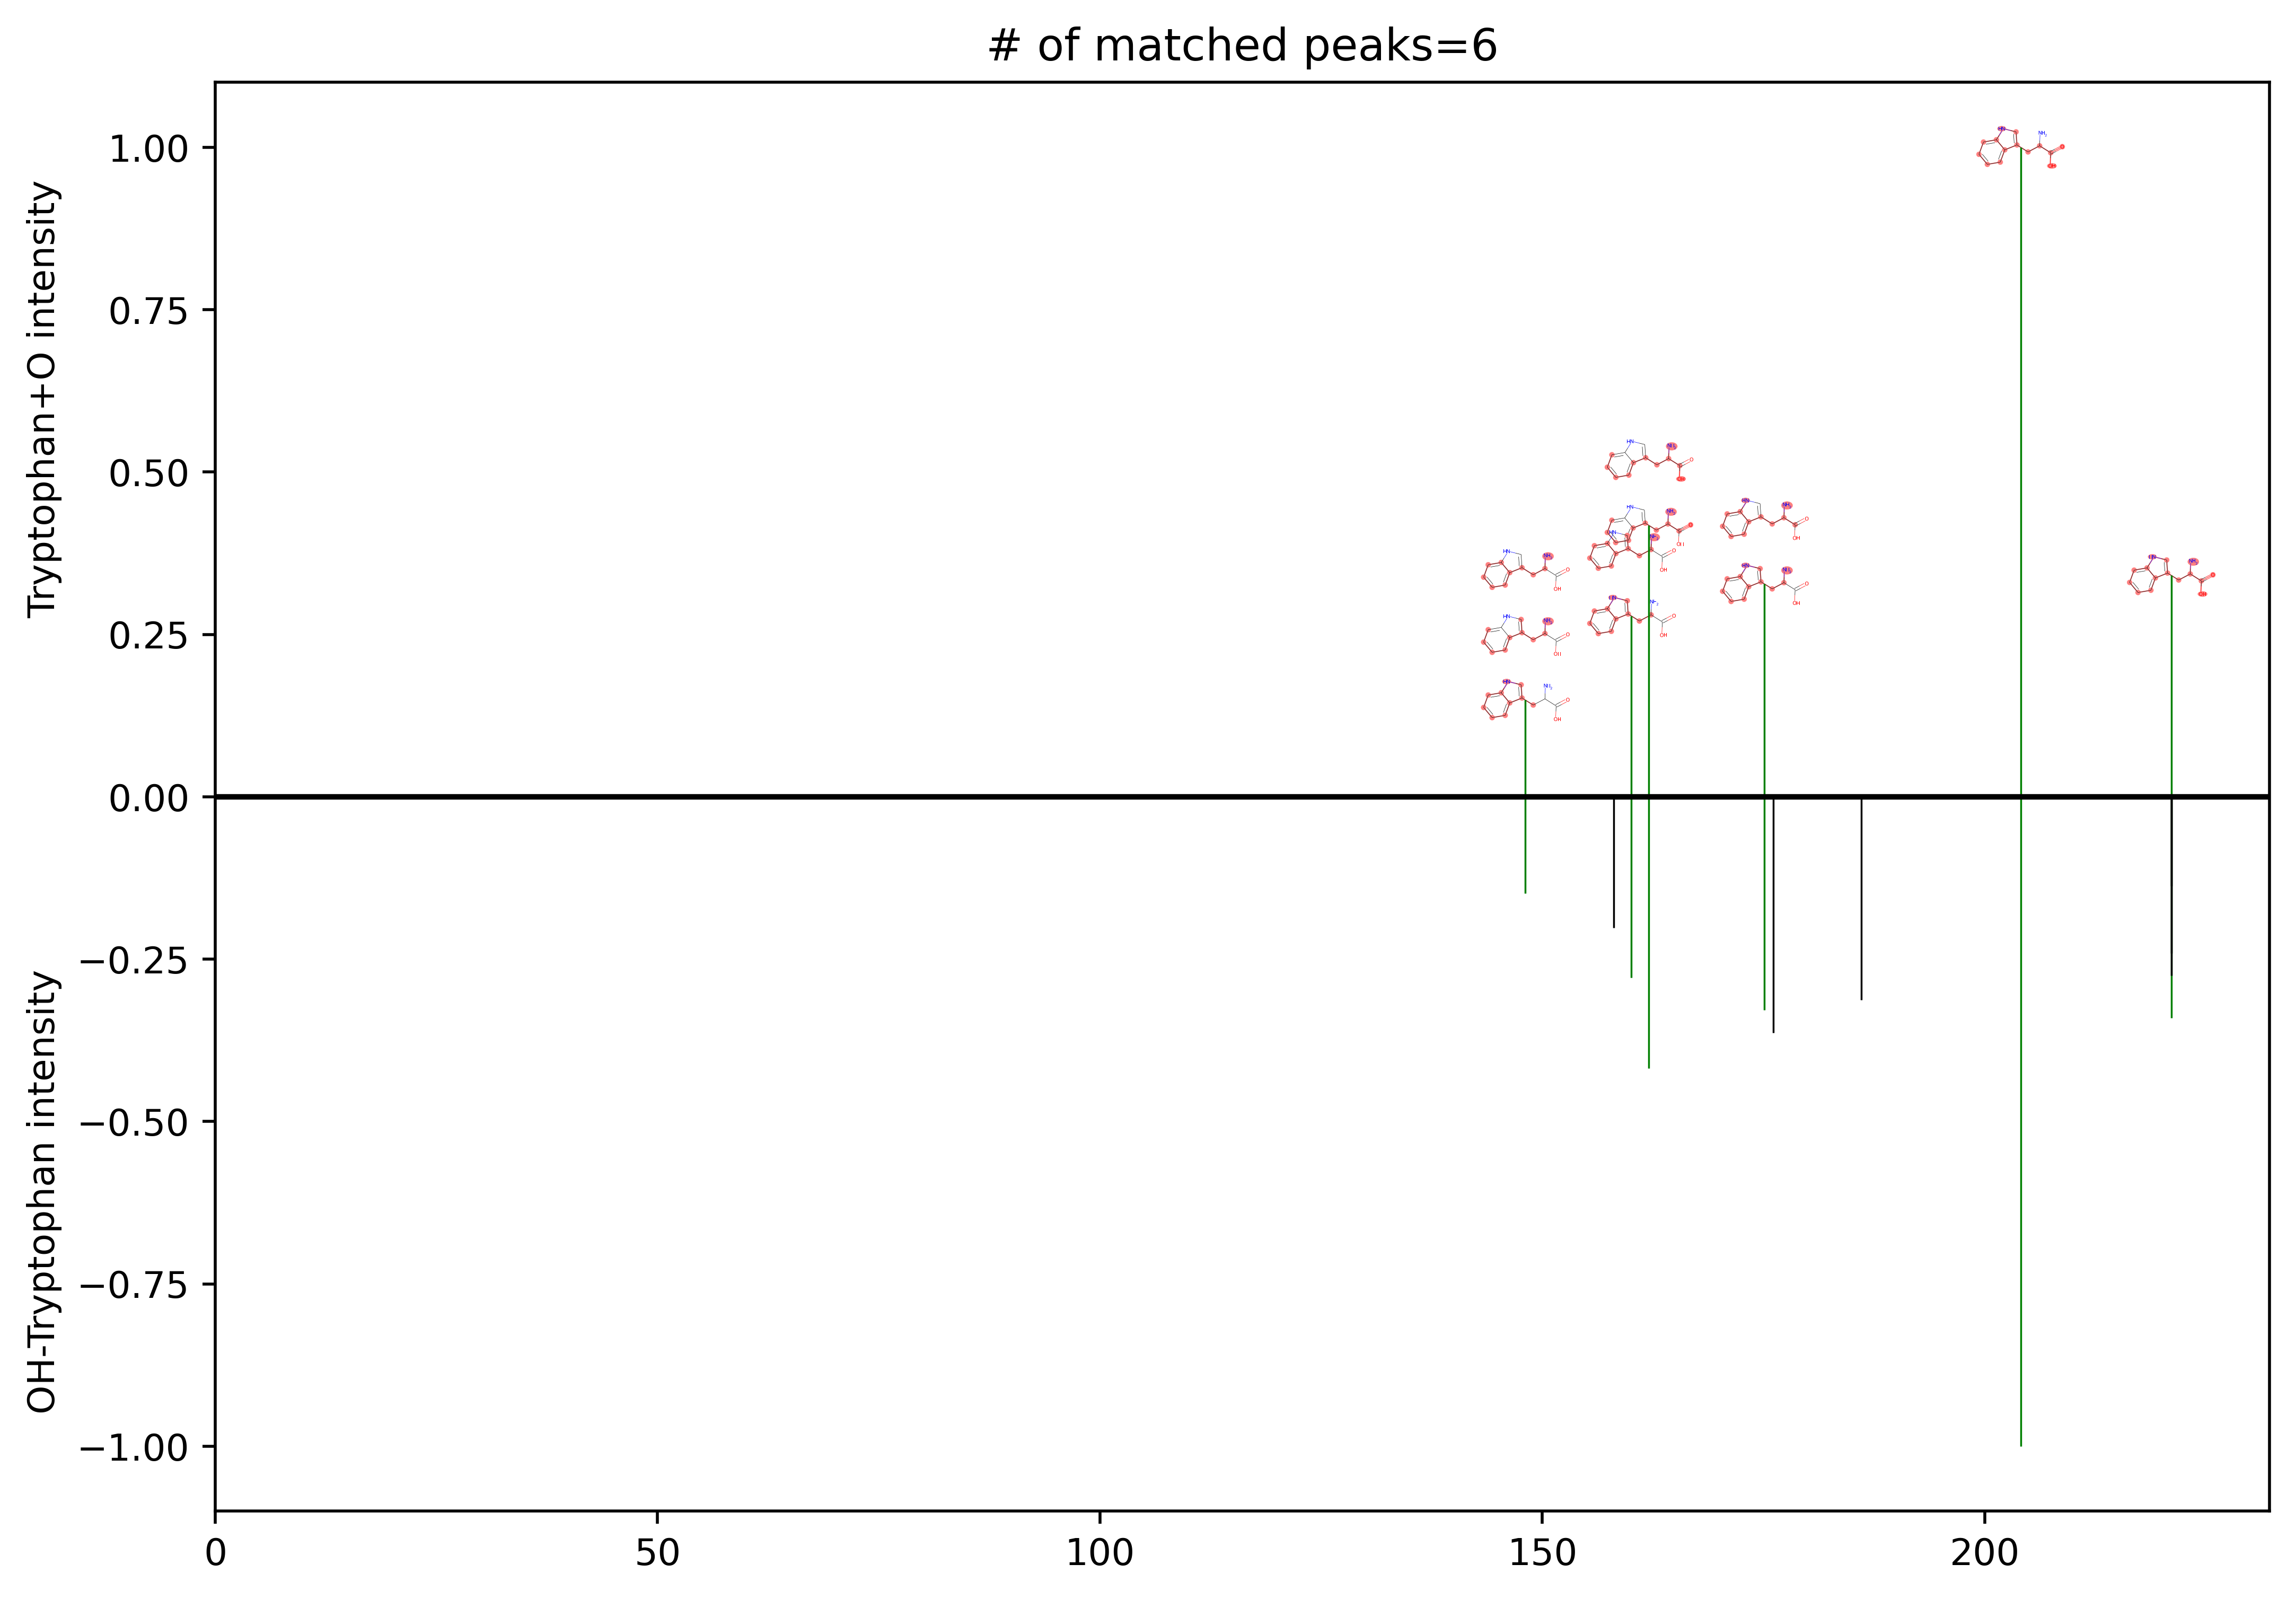

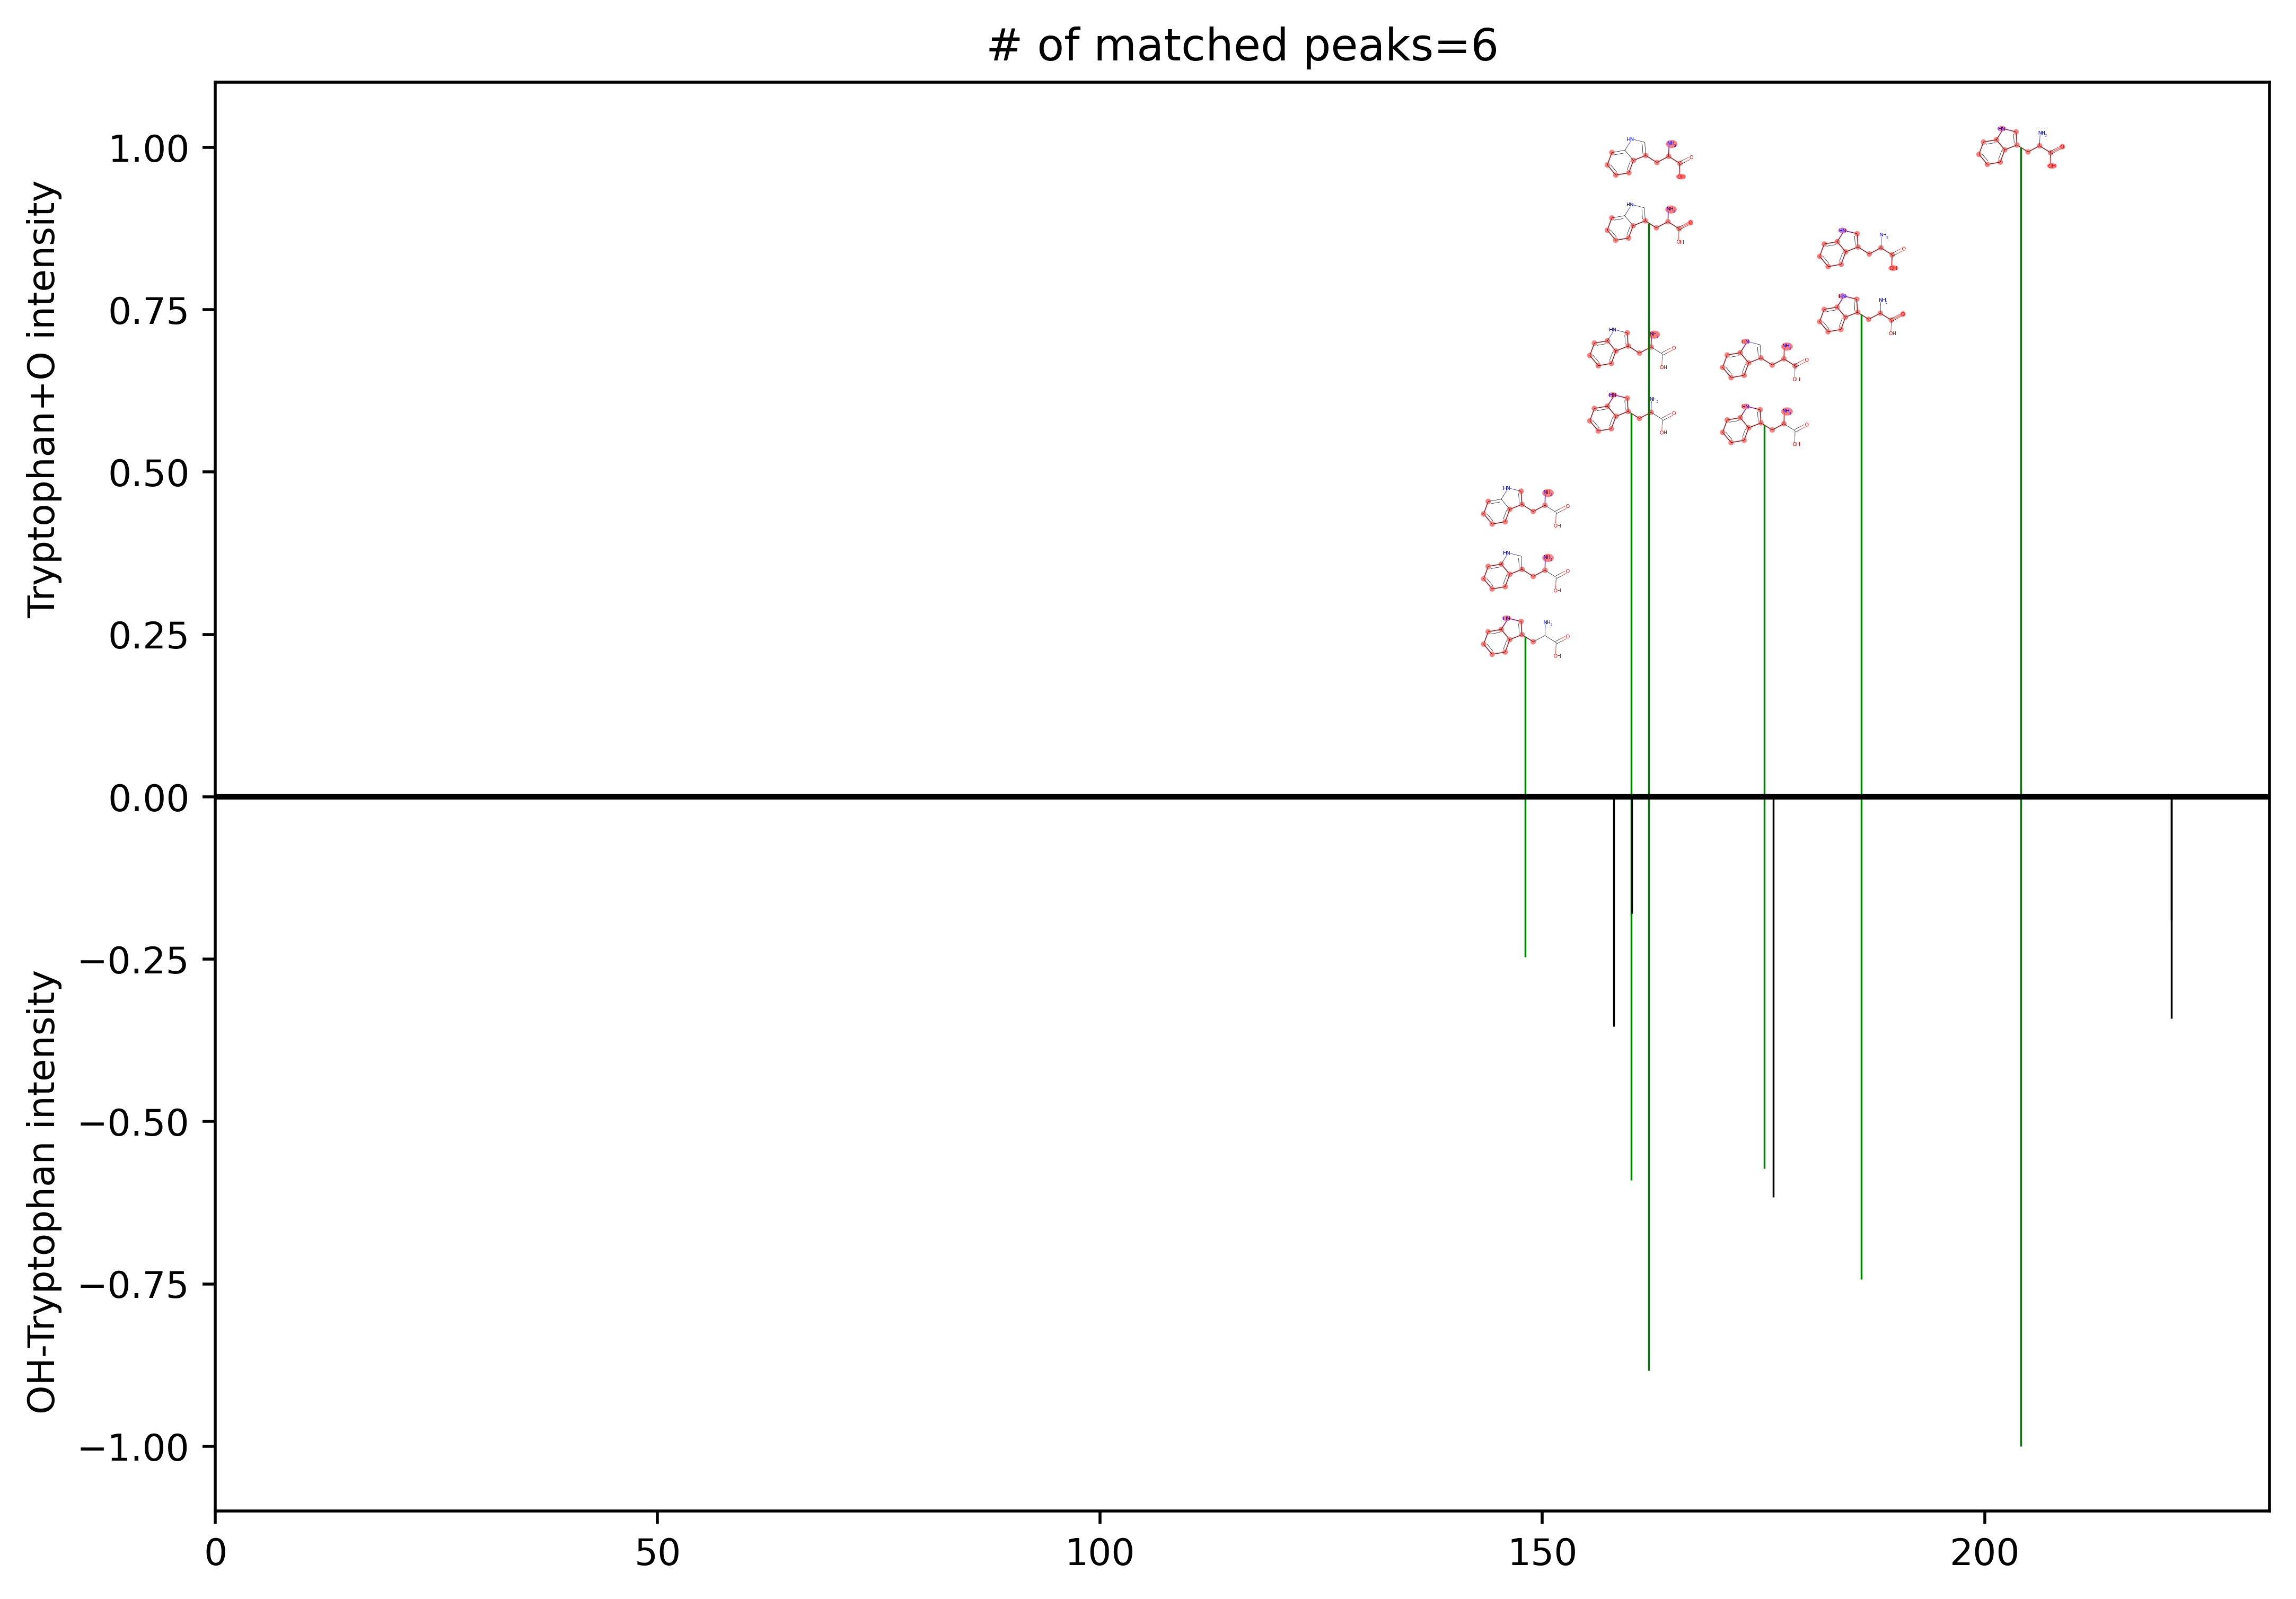

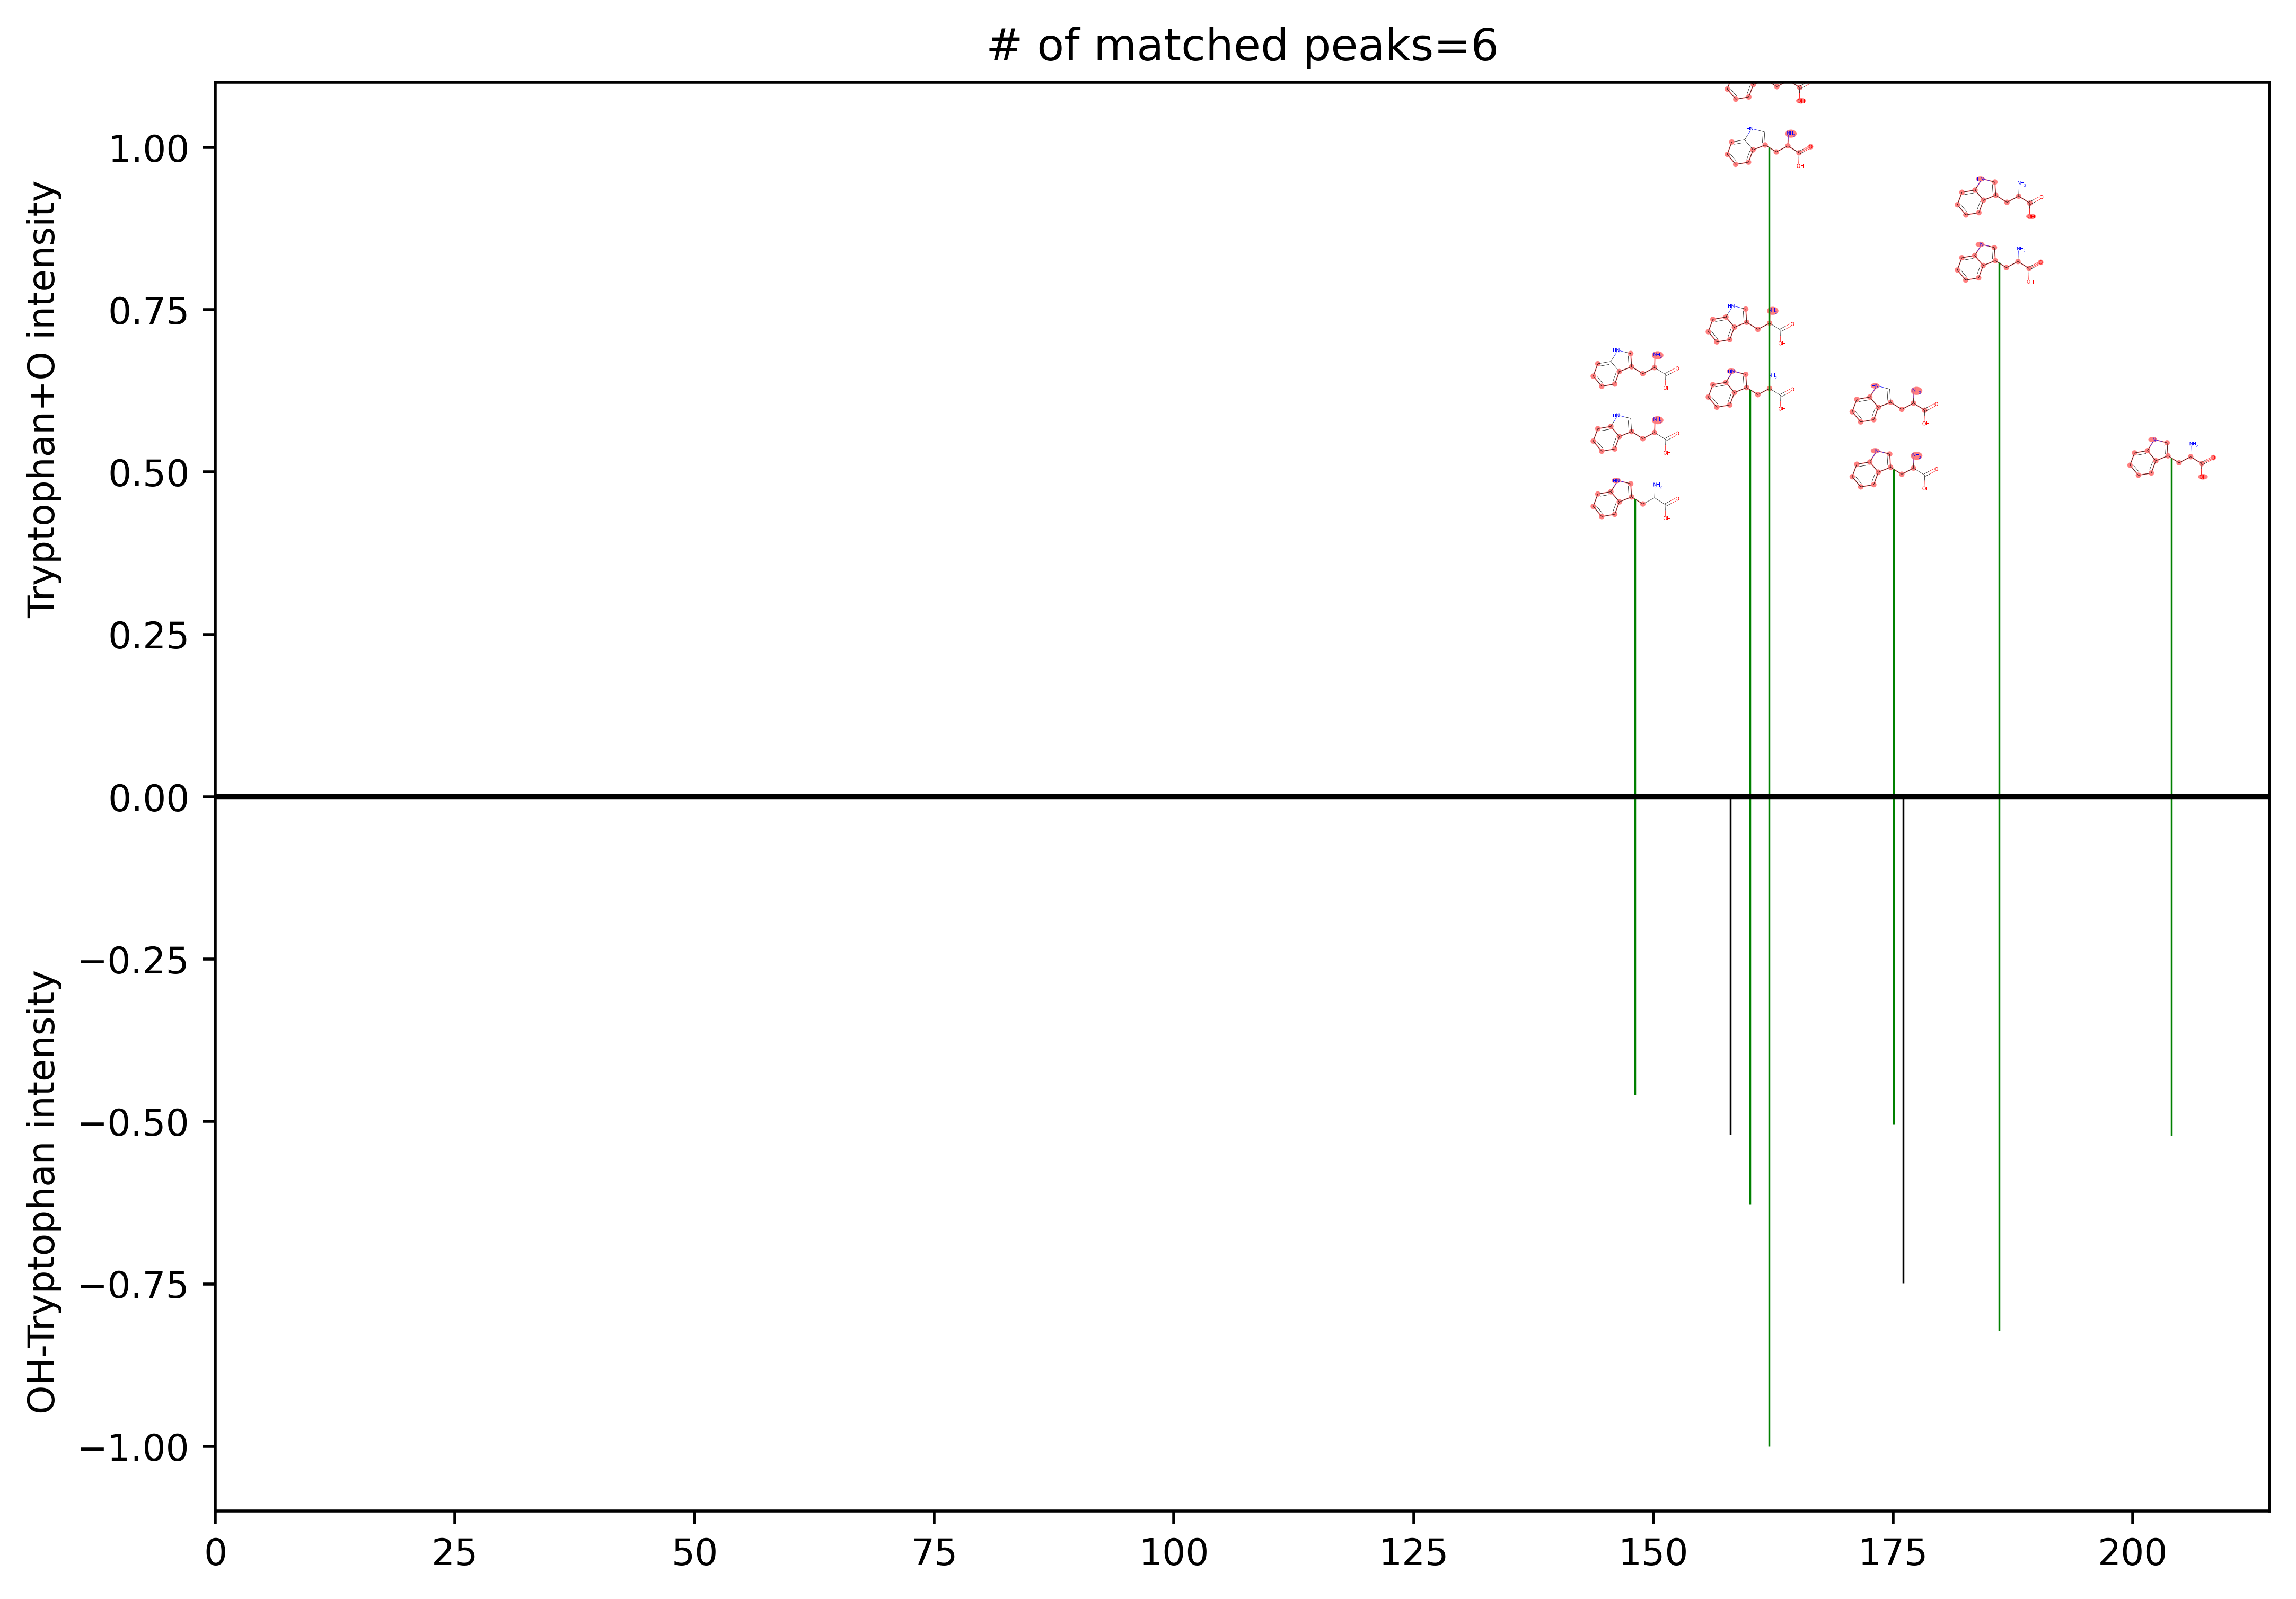

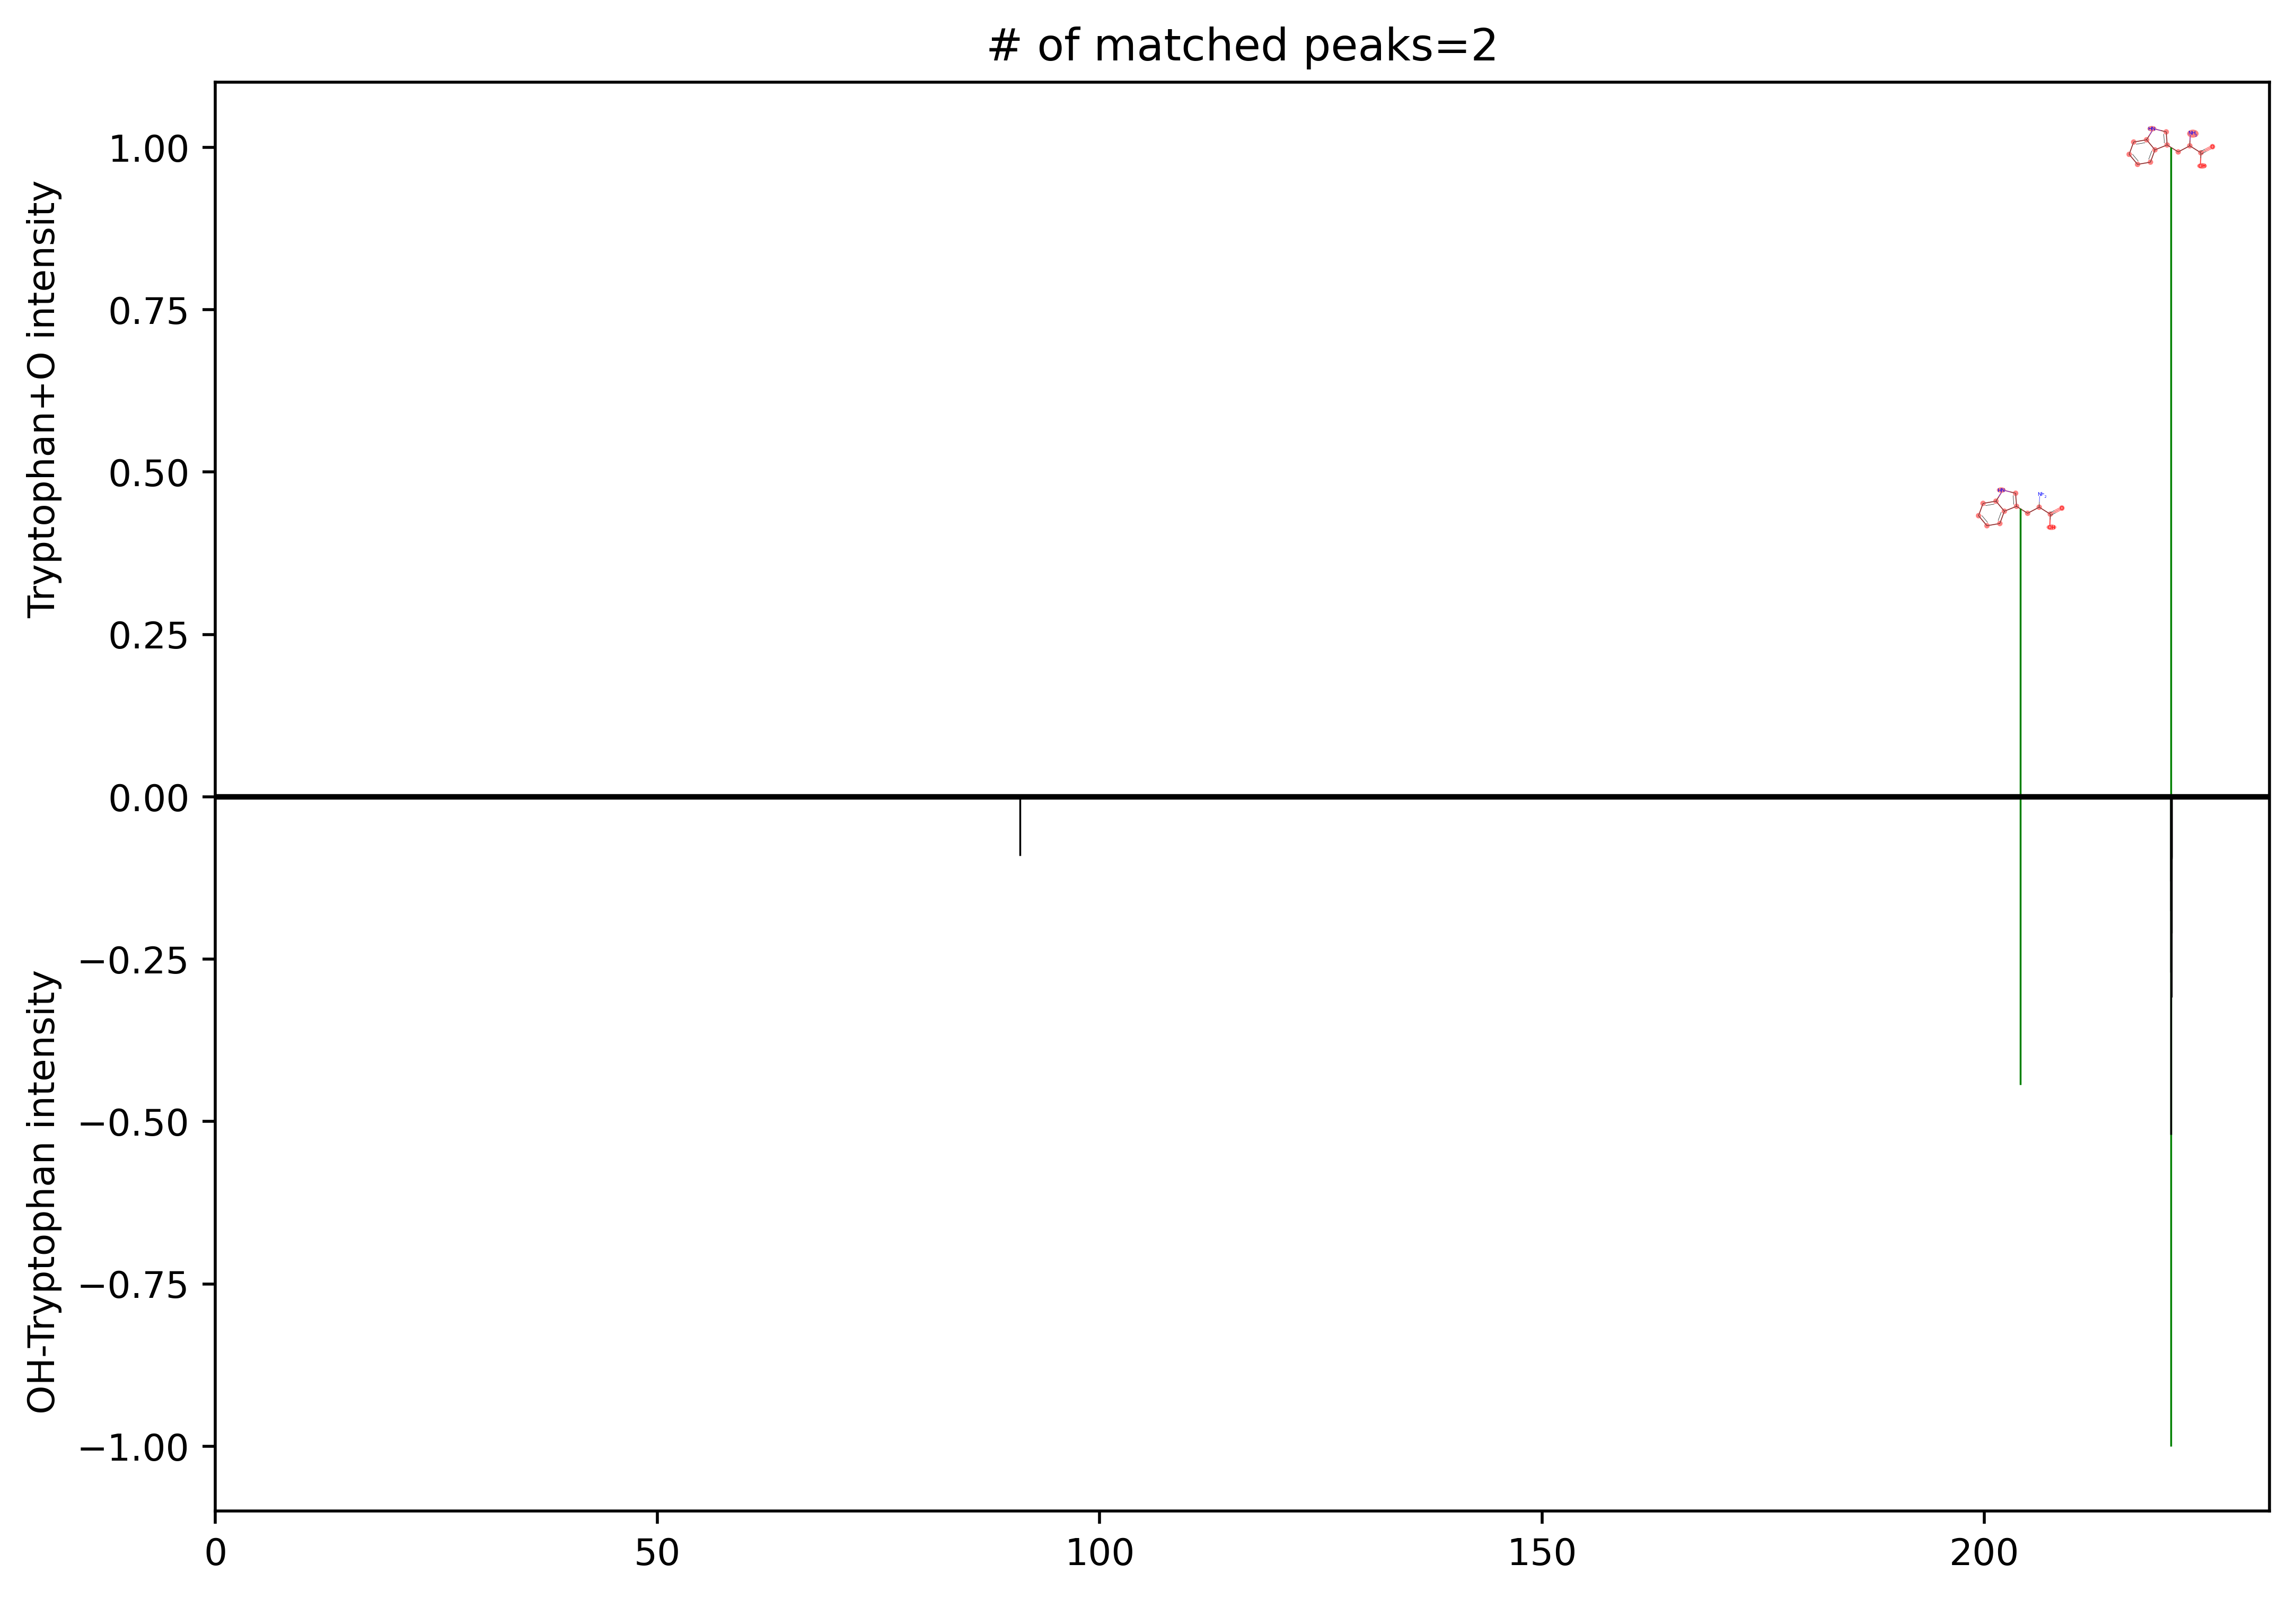

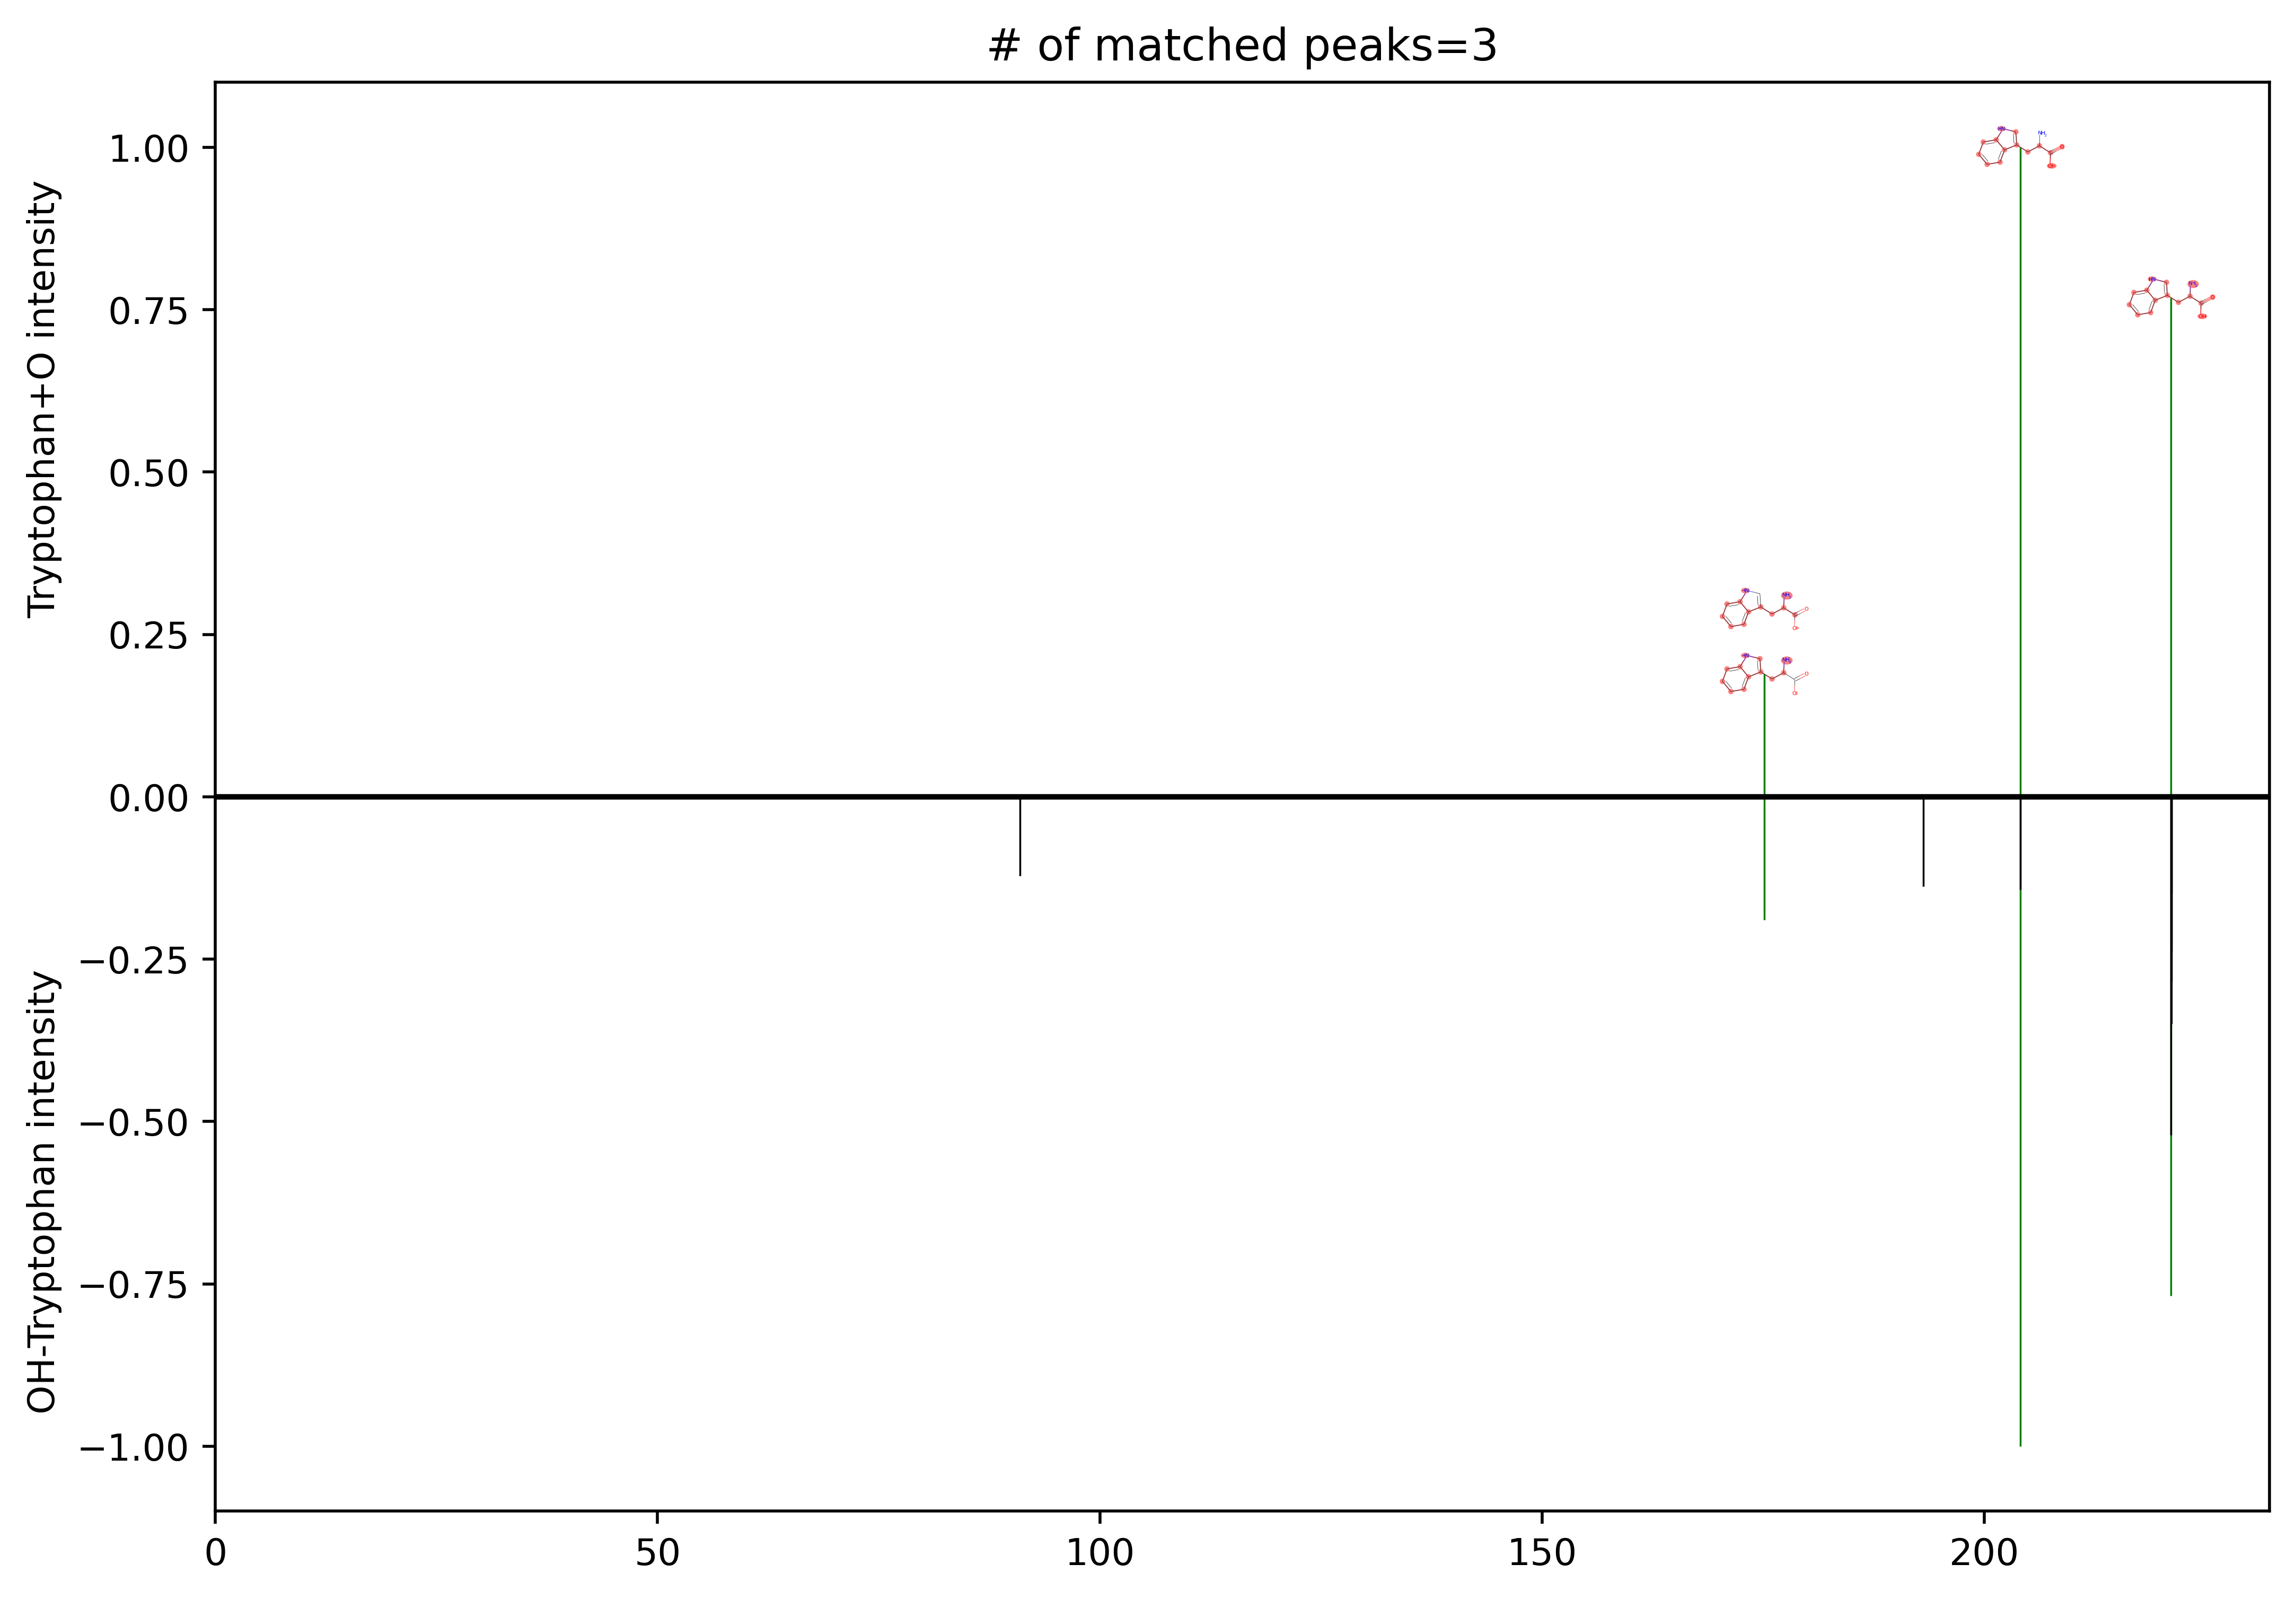

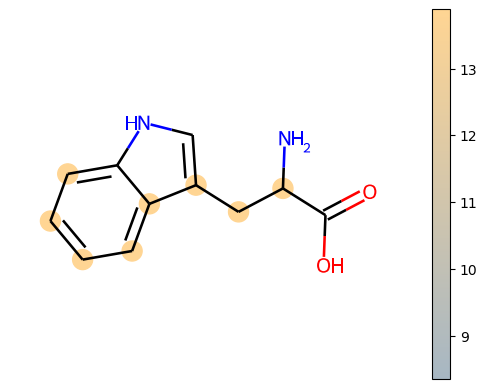

In [17]:
meta1 = {
    'real_smi': r'C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N',
    'cmpd_name': 'Tryptophan',
    'precursor': 205.0972,
    'ref_spec': 'nist_1188350',
}
meta2 = {
    'cmpd_name': 'OH-Tryptophan',
    'precursor': 221.0921,
    'ref_spec': '/home/roger/ms_collaborators/broad-Julian/spec_files/{}.ms'.format('mxp4310')
}
form_diff = '+O'

broad_config = copy.deepcopy(config)
broad_config['nce'] = True
broad_config['max_nodes'] = 500
broad_config['sparse_k'] = 500

# Run ICEBERG to predict spectra for mol1
result_path, pmz = iceberg_prediction([meta1["real_smi"]], [10, 20, 30, 40, 50], **broad_config)

imgs = modi_finder(
    form_diff, result_path, meta1["real_smi"],
    meta1["cmpd_name"], meta1["precursor"], meta1["ref_spec"], "nist",
    meta2["cmpd_name"], meta2["precursor"], meta2["ref_spec"], "ms",
    nce1=False, nce2=True,
    topk_peaks=15, return_thresh=0.1,
)

## Tripeptite

[Lys-Pro-Leu] Found target mol at 1/347, ent_dist=0.255


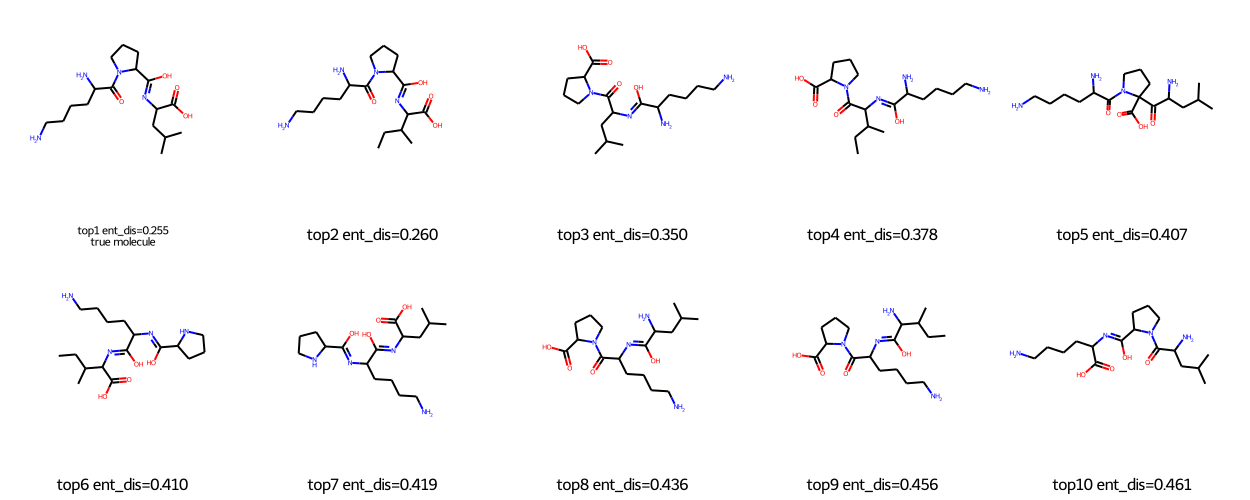

In [20]:
broad_elucidation('mxp4039', 'C17H32N4O4', r'CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N', 'Lys-Pro-Leu')

In [14]:
Chem.MolToInchi(Chem.MolFromSmiles(common.rm_stereo(r'CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N')), options='/FixedH')

'InChI=1/C17H32N4O4/c1-11(2)10-13(17(24)25)20-15(22)14-7-5-9-21(14)16(23)12(19)6-3-4-8-18/h11-14H,3-10,18-19H2,1-2H3,(H,20,22)(H,24,25)/f/h20,24H'

In [15]:
Chem.MolToInchi(Chem.MolFromSmiles(common.rm_stereo(r'CC(C)C[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N')))

'InChI=1S/C17H32N4O4/c1-11(2)10-13(17(24)25)20-15(22)14-7-5-9-21(14)16(23)12(19)6-3-4-8-18/h11-14H,3-10,18-19H2,1-2H3,(H,20,22)(H,24,25)'

In [ ]:
broad_elucidation('mxp4040', 'C17H32N4O4', r'CC[C@H](C)[C@@H](C(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)N', 'Lys-Pro-Ile')

In [ ]:
broad_elucidation('mxp4041', 'C17H32N4O4', r'CC(C)C[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)O)N', 'Leu-Pro-Lys')

[Ile-Pro-Lys] Found target mol at 1/347, ent_dist=0.177


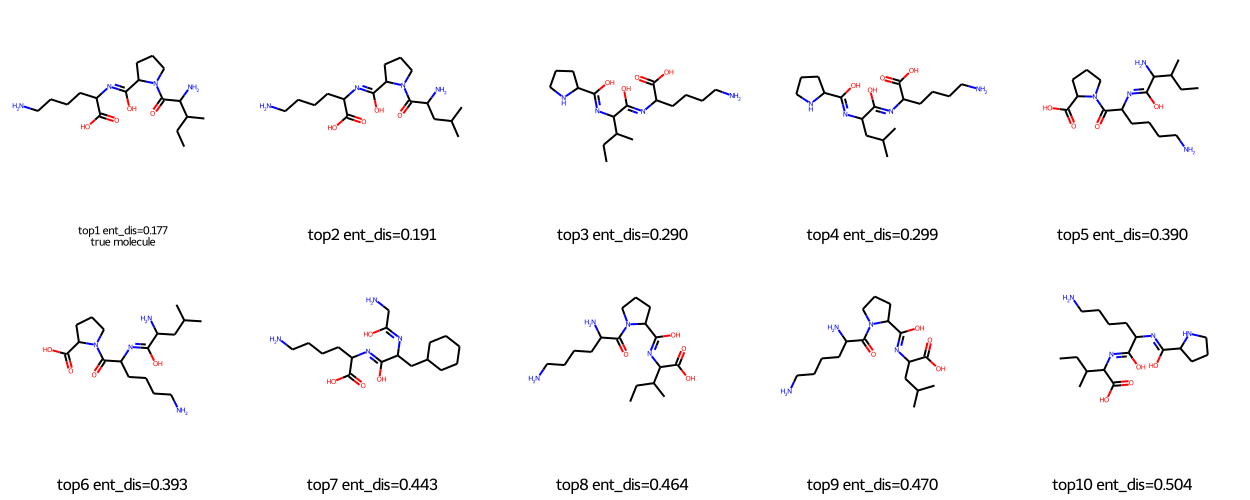

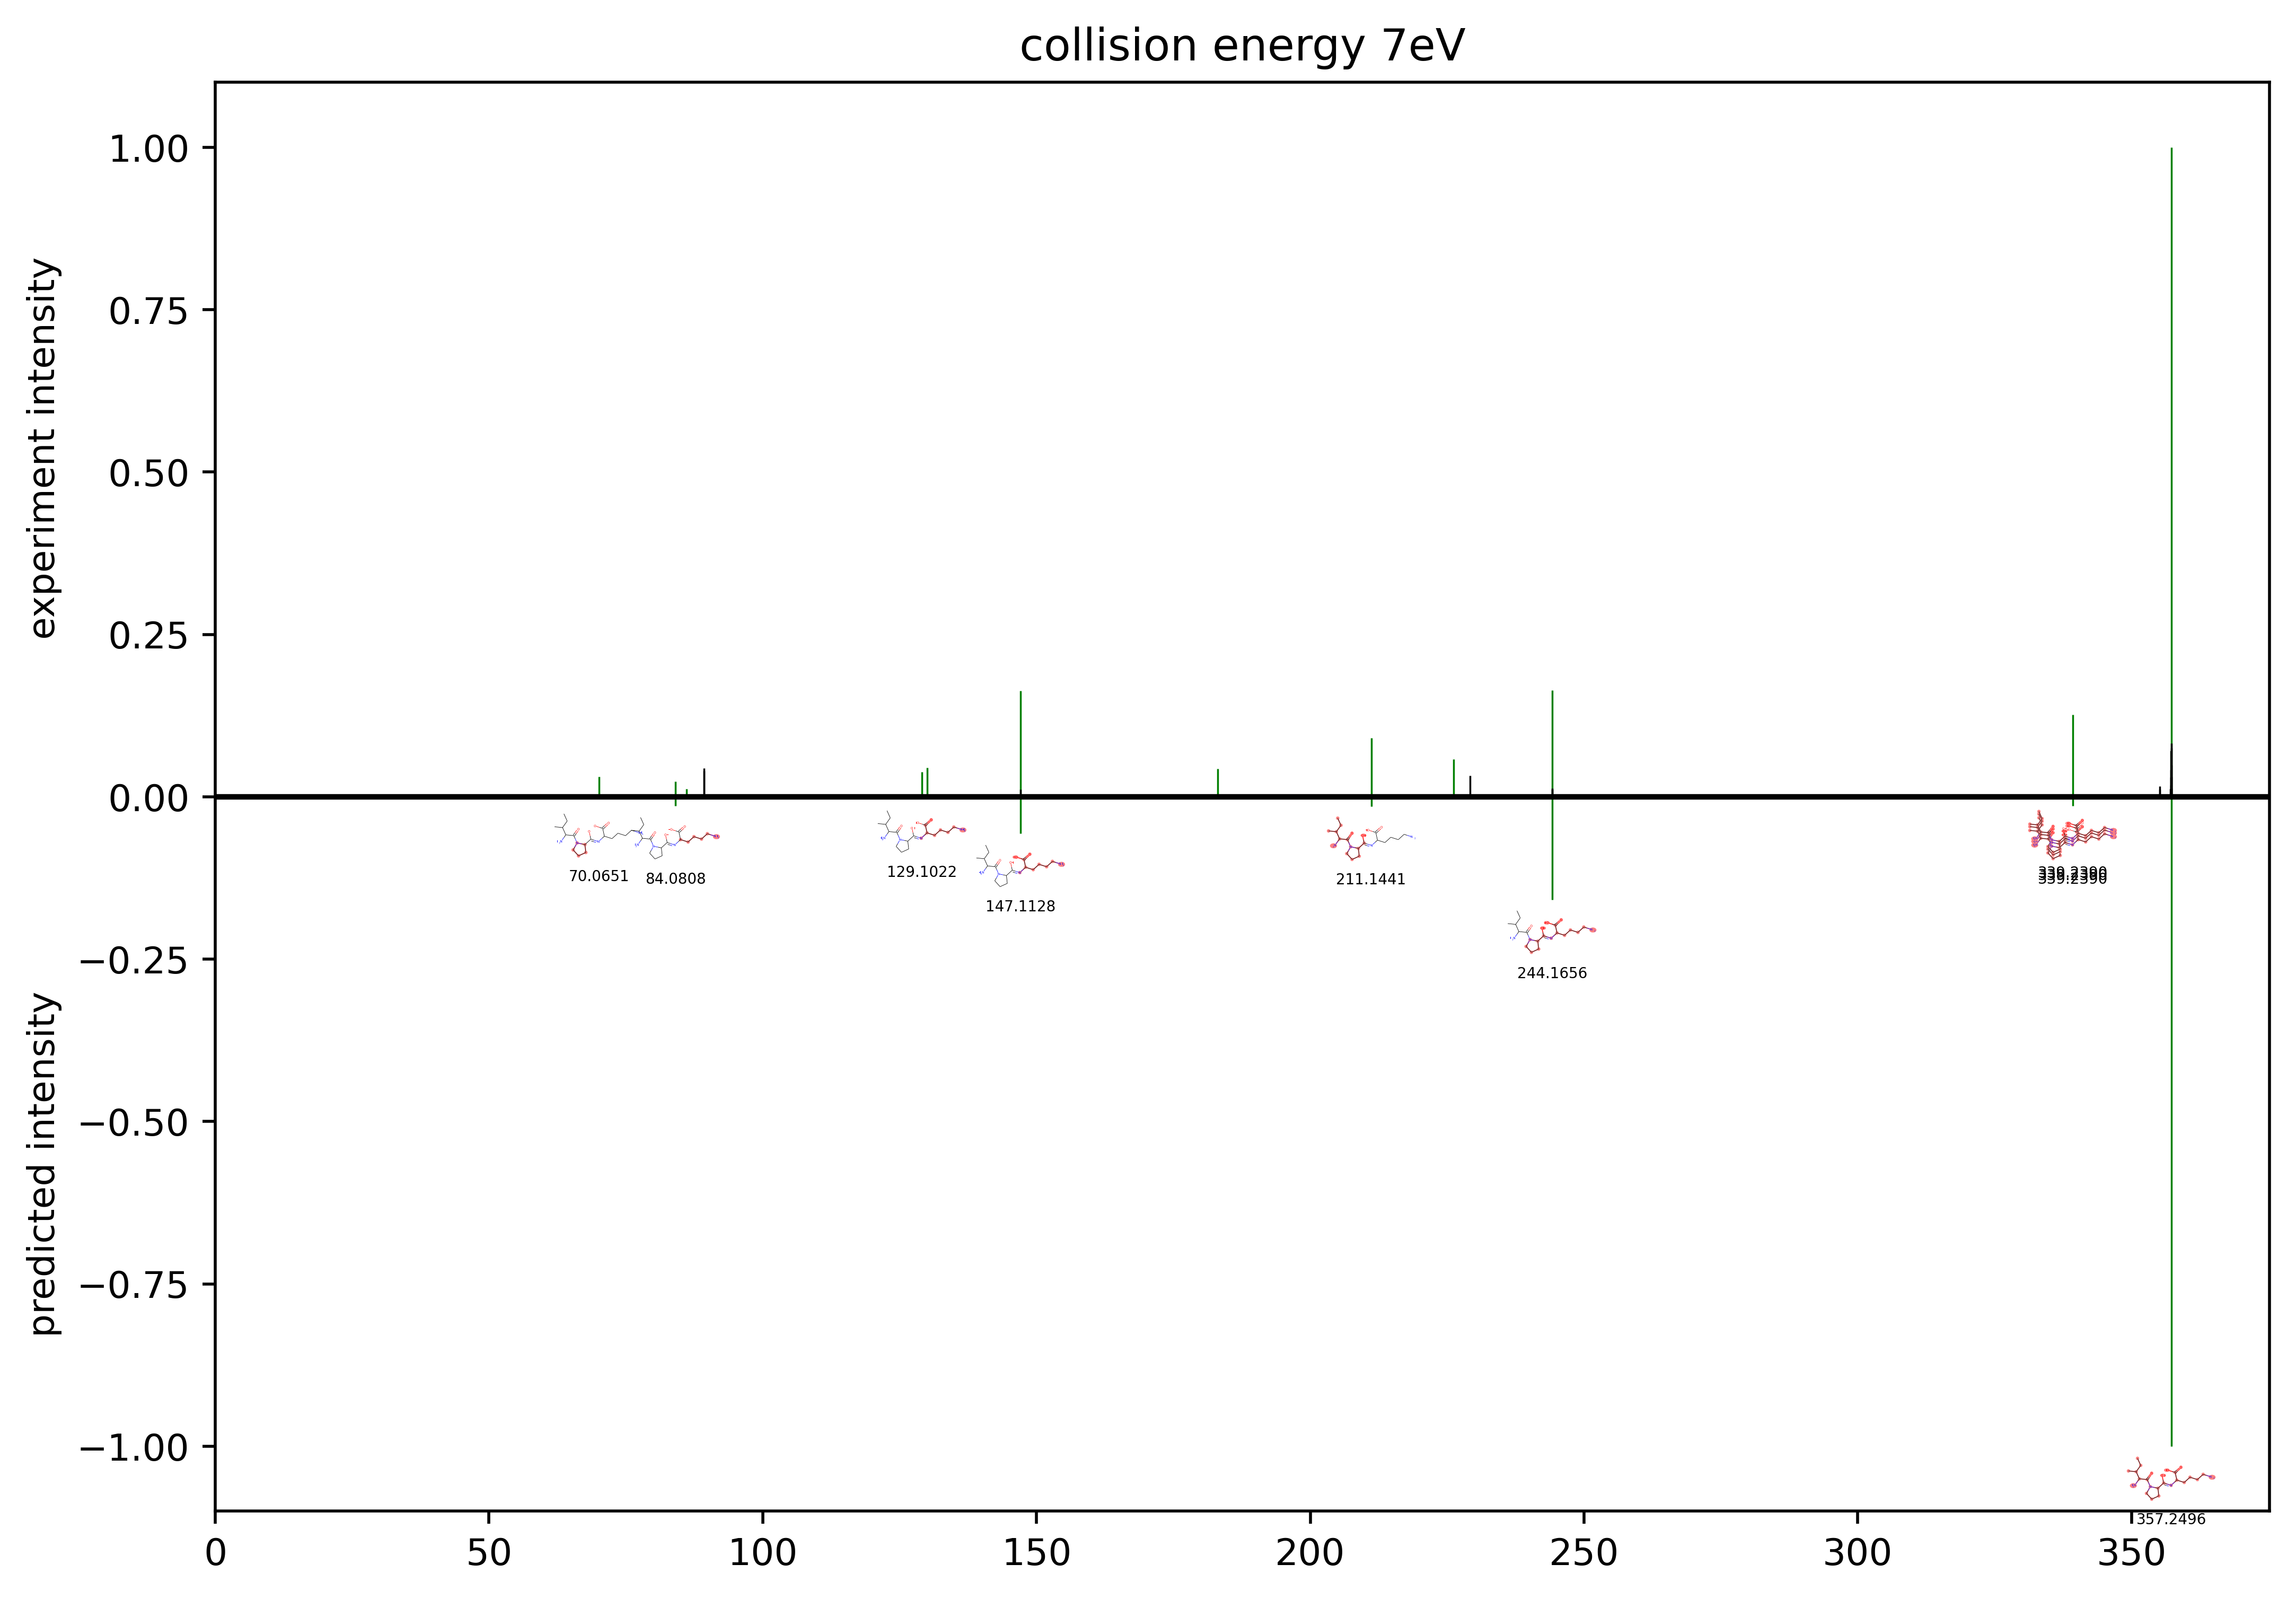

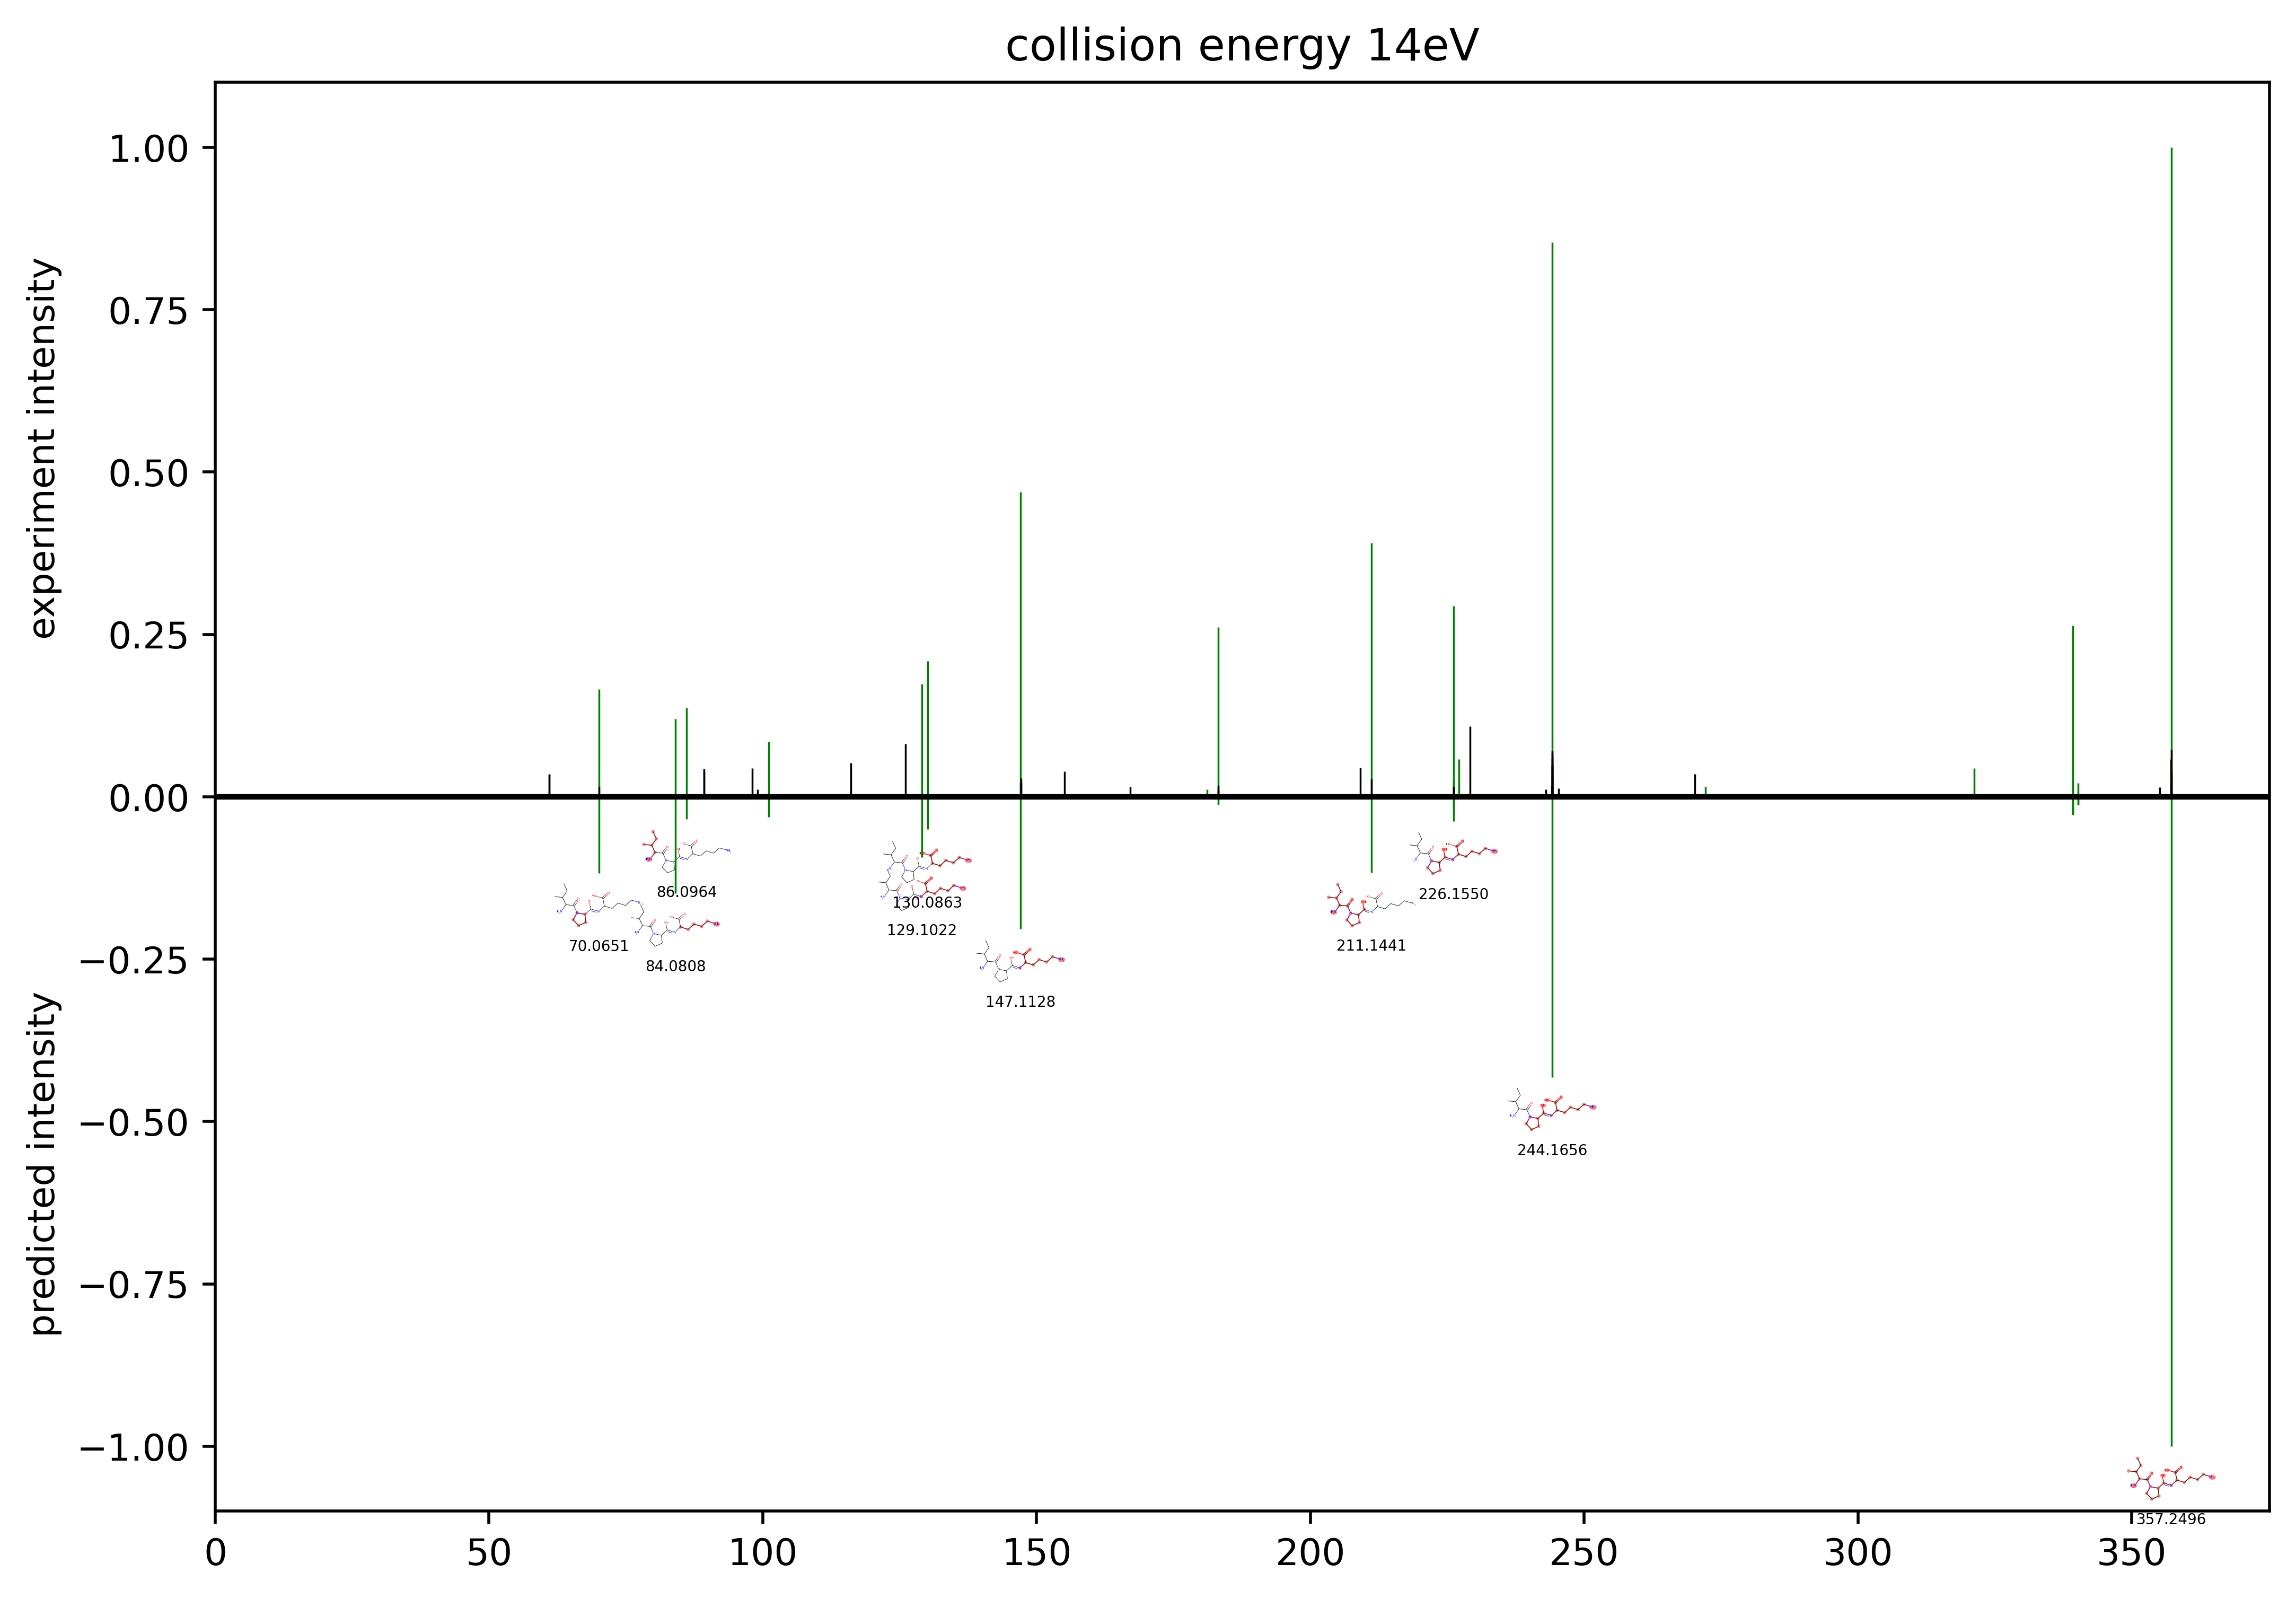

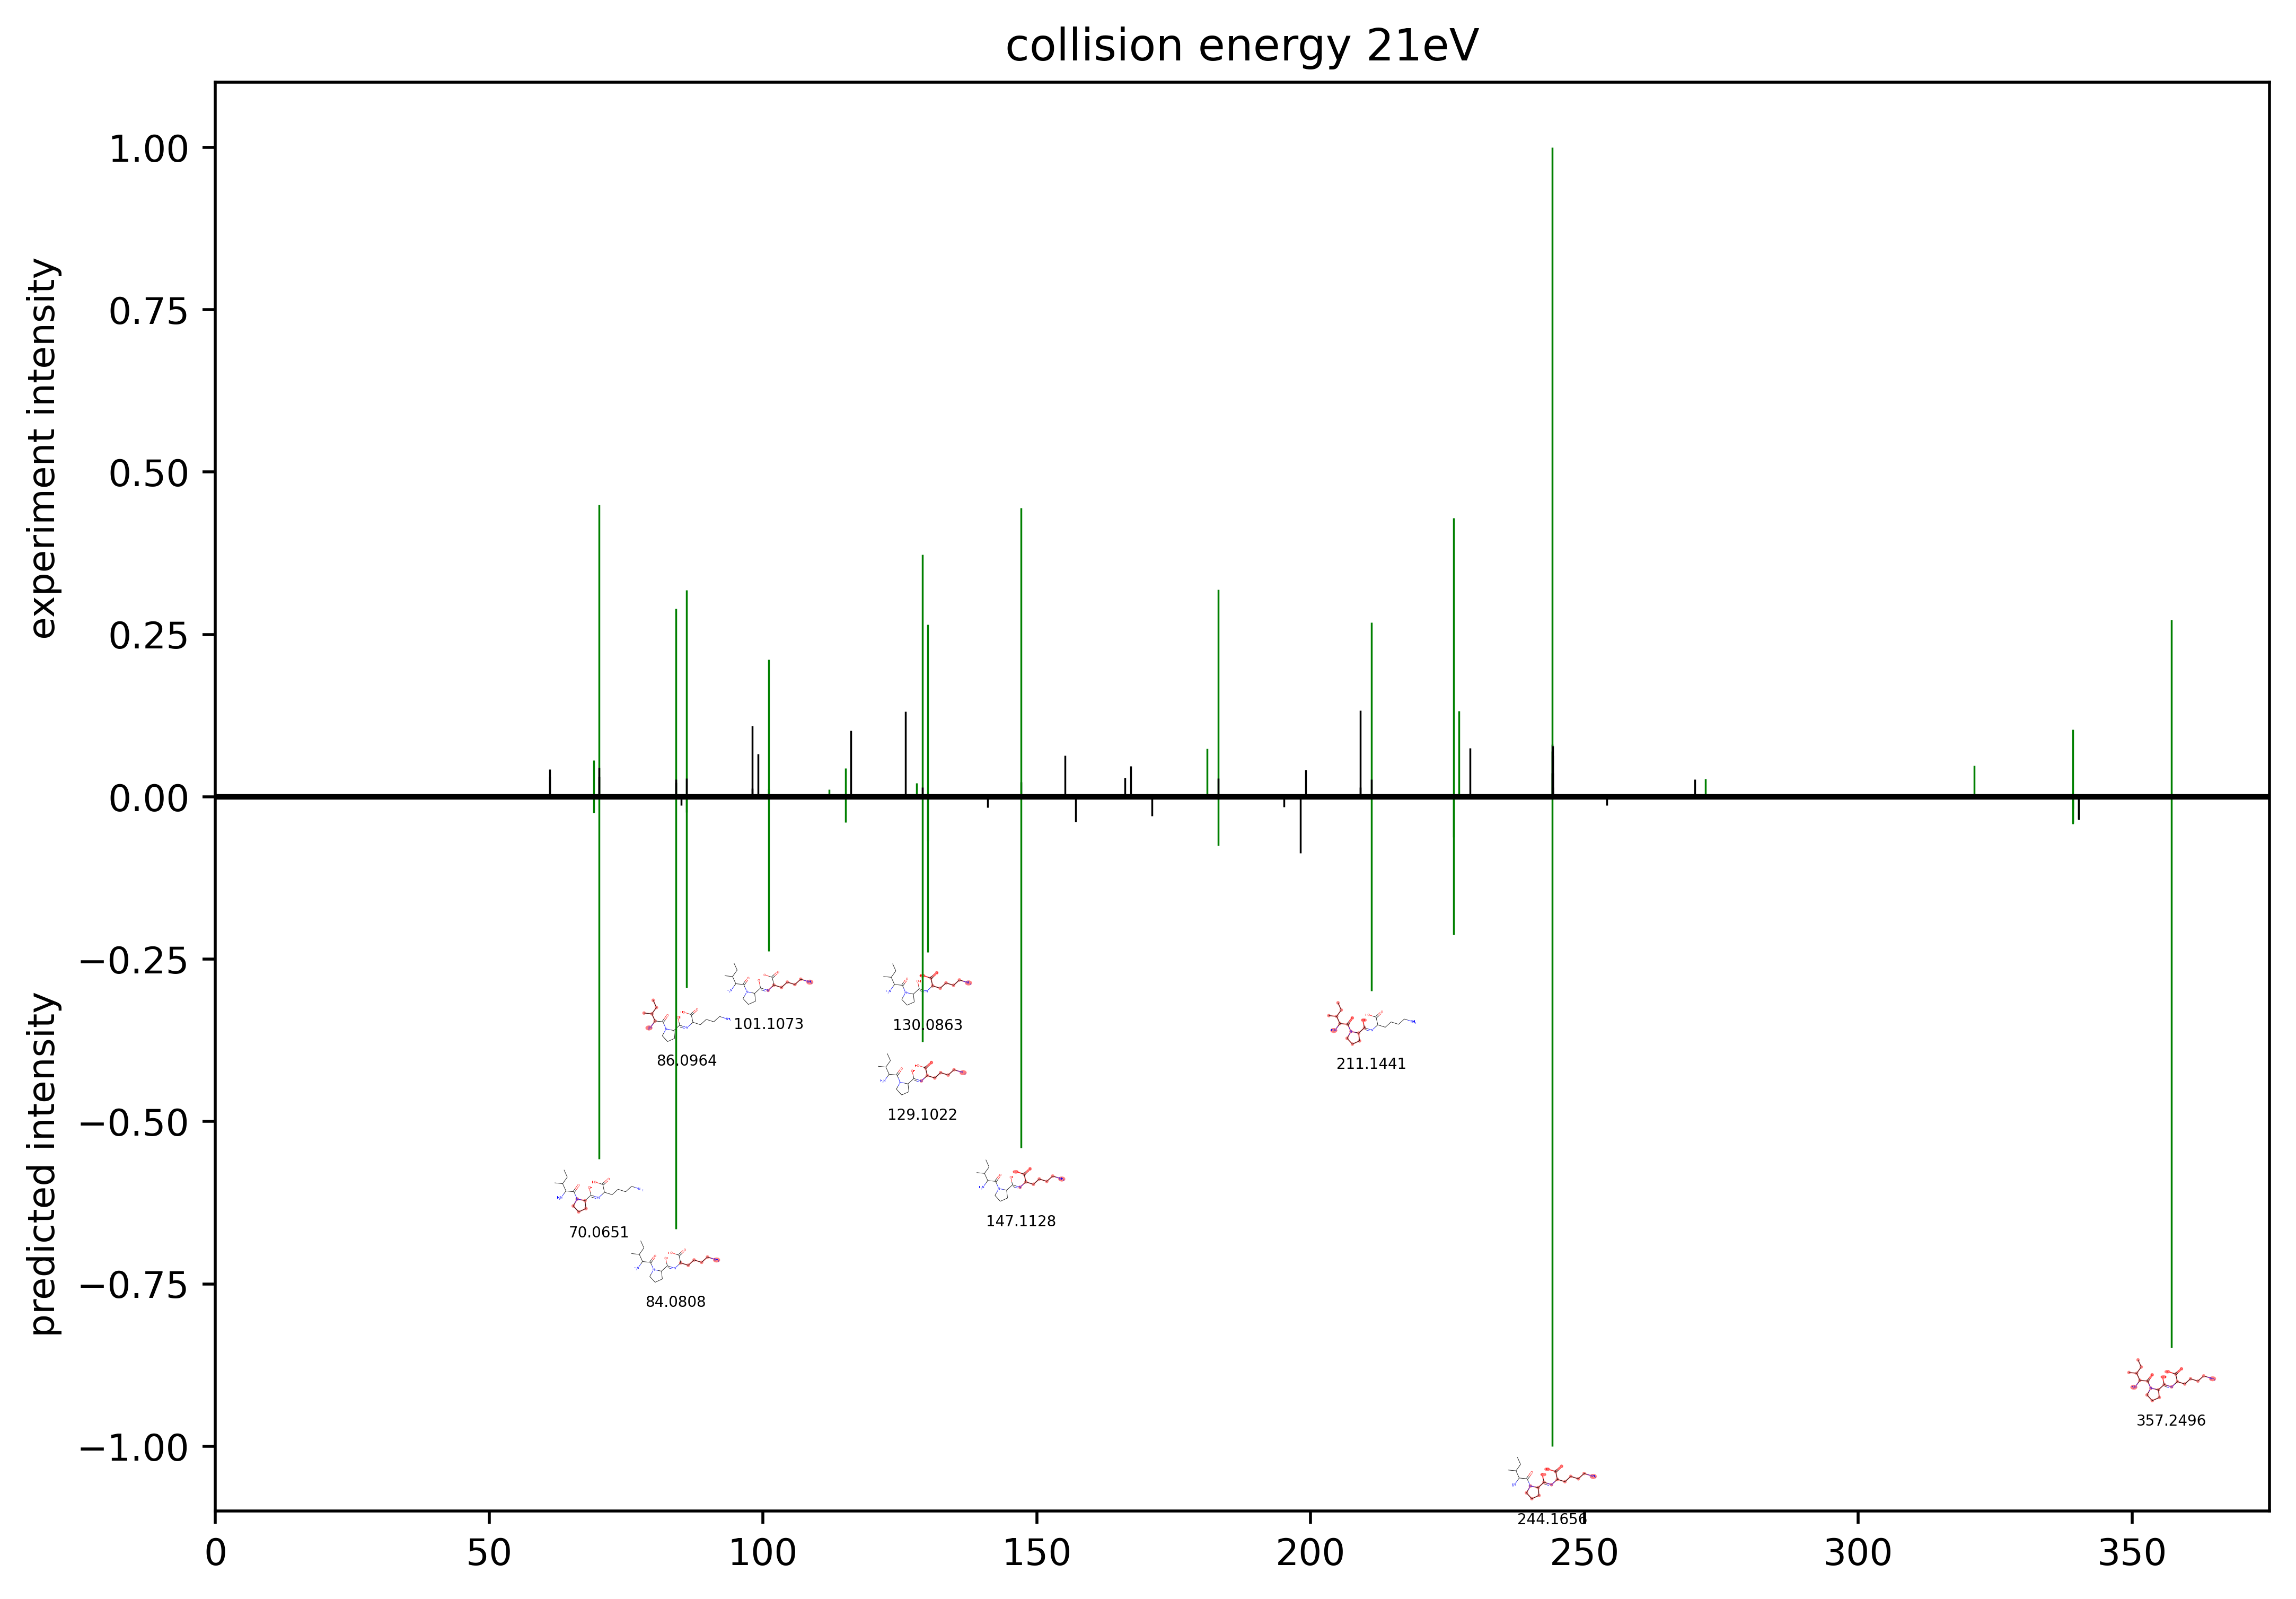

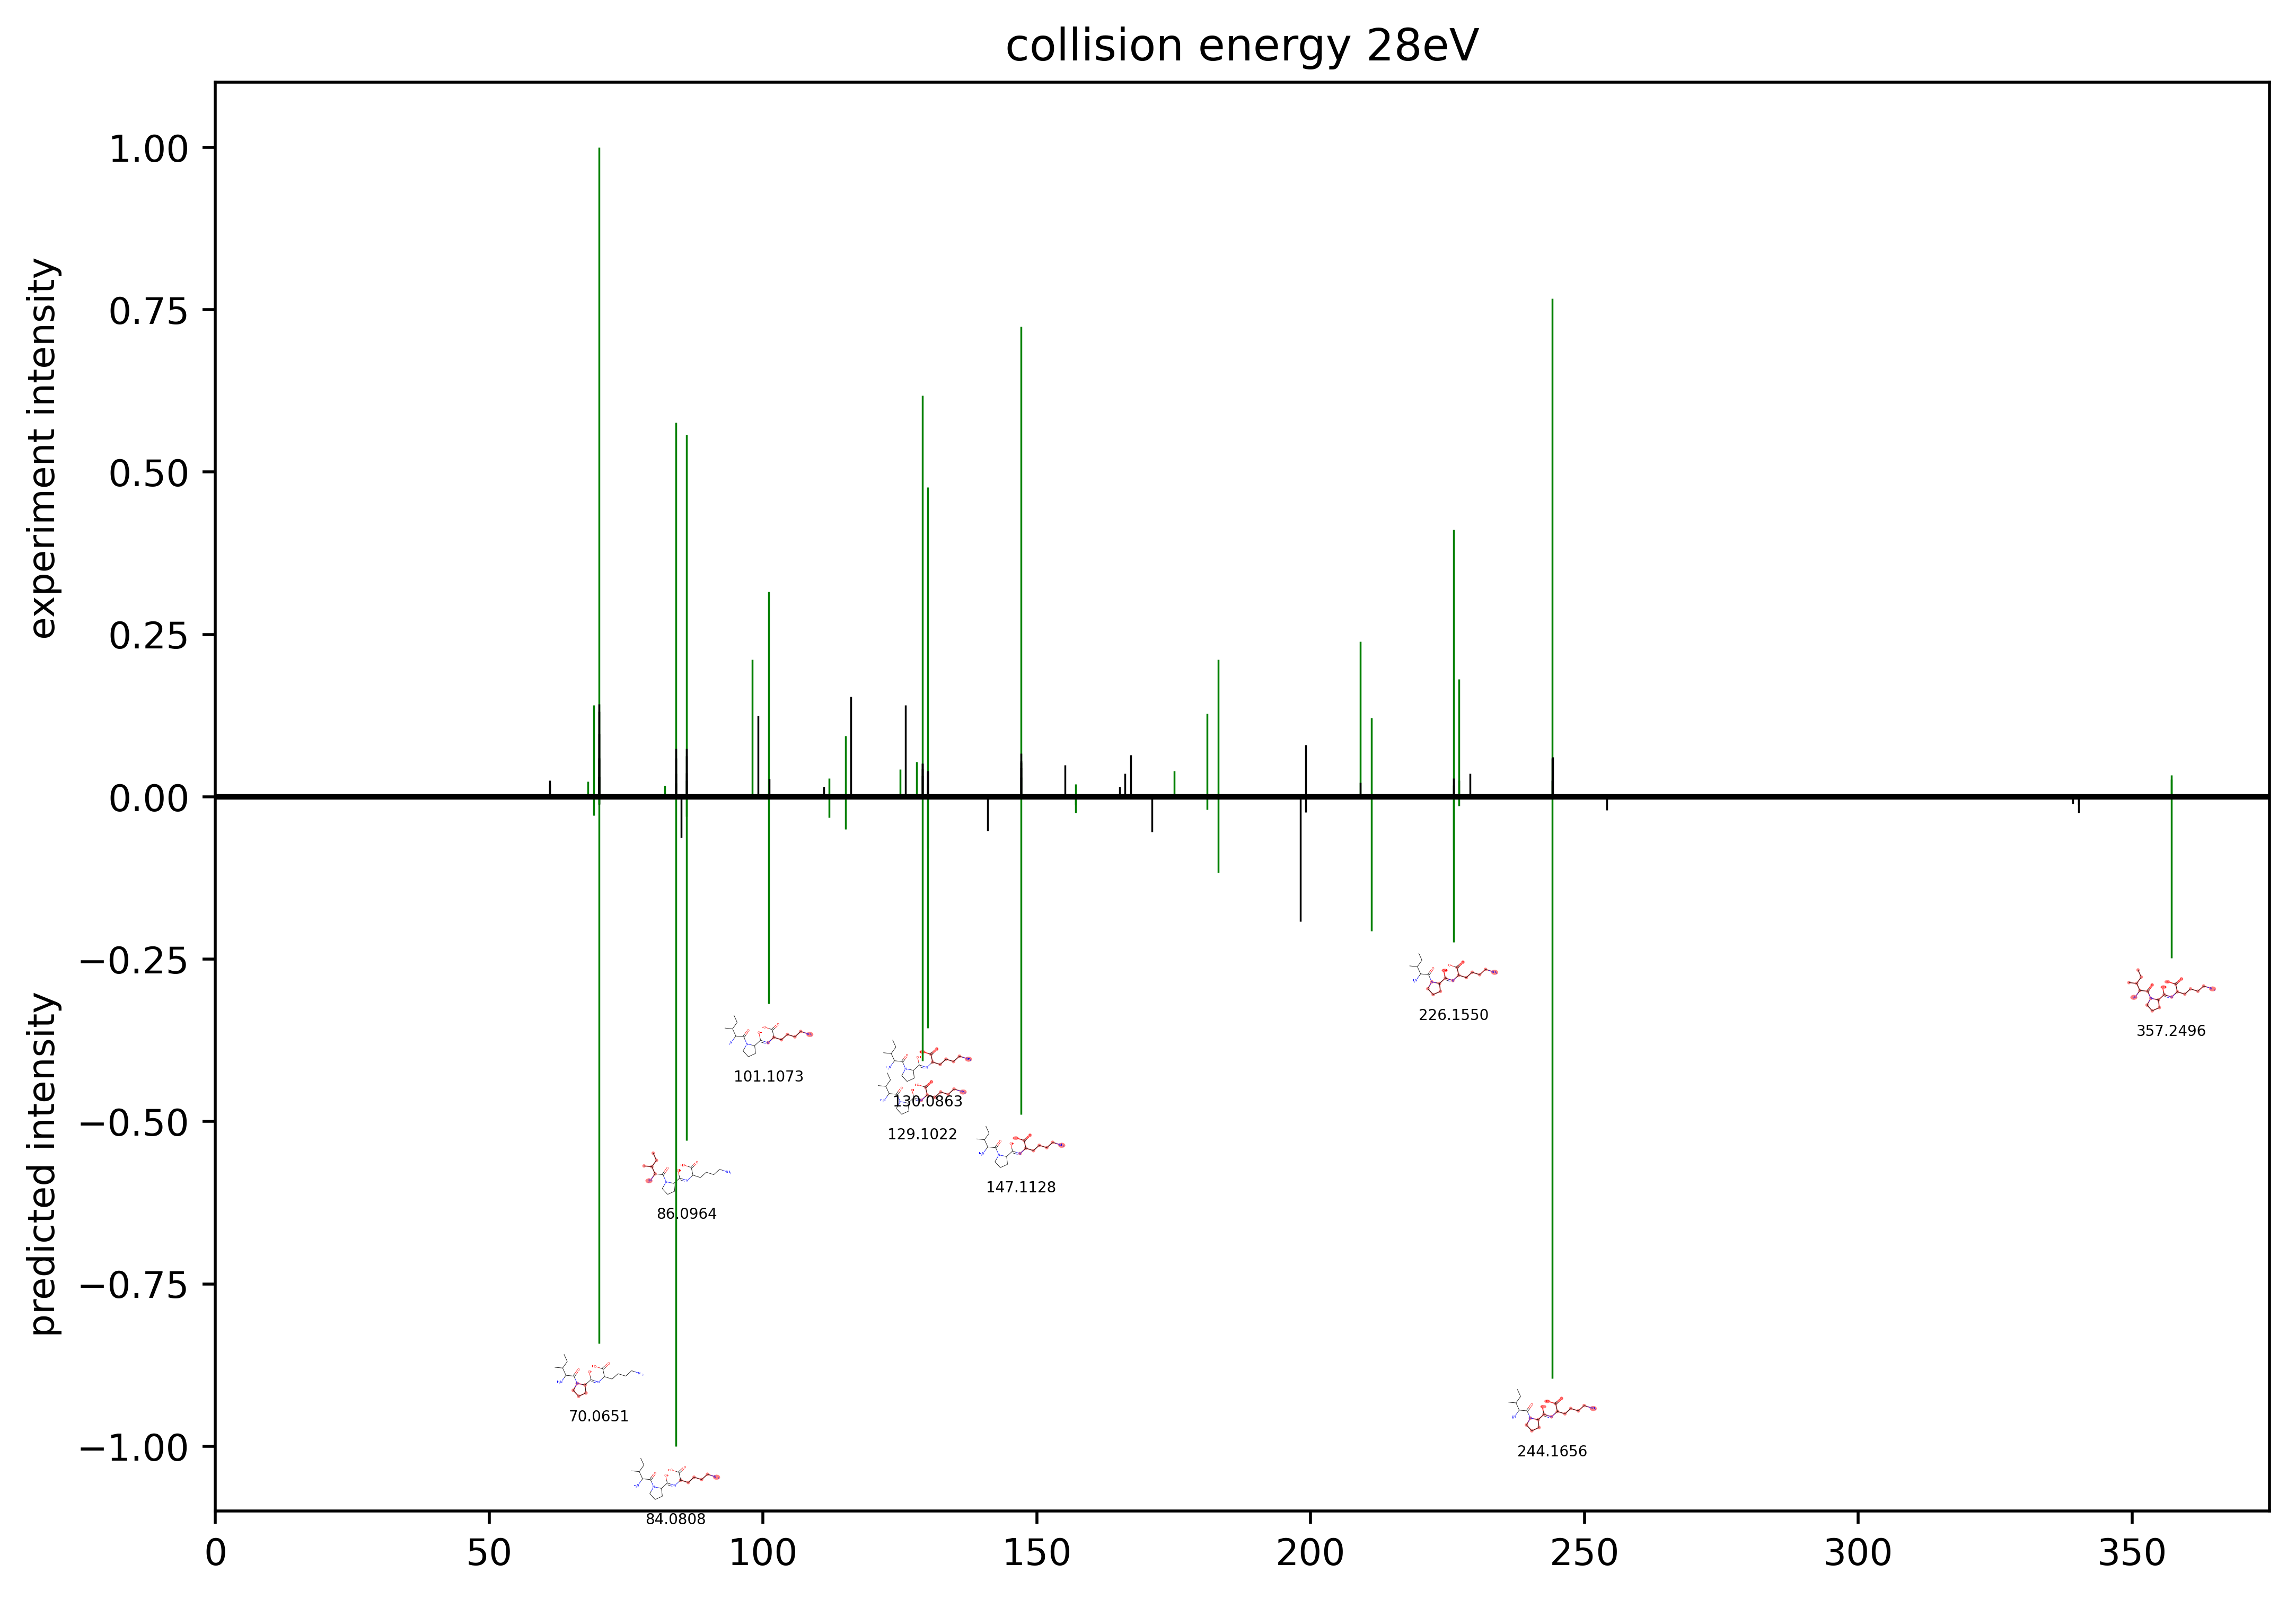

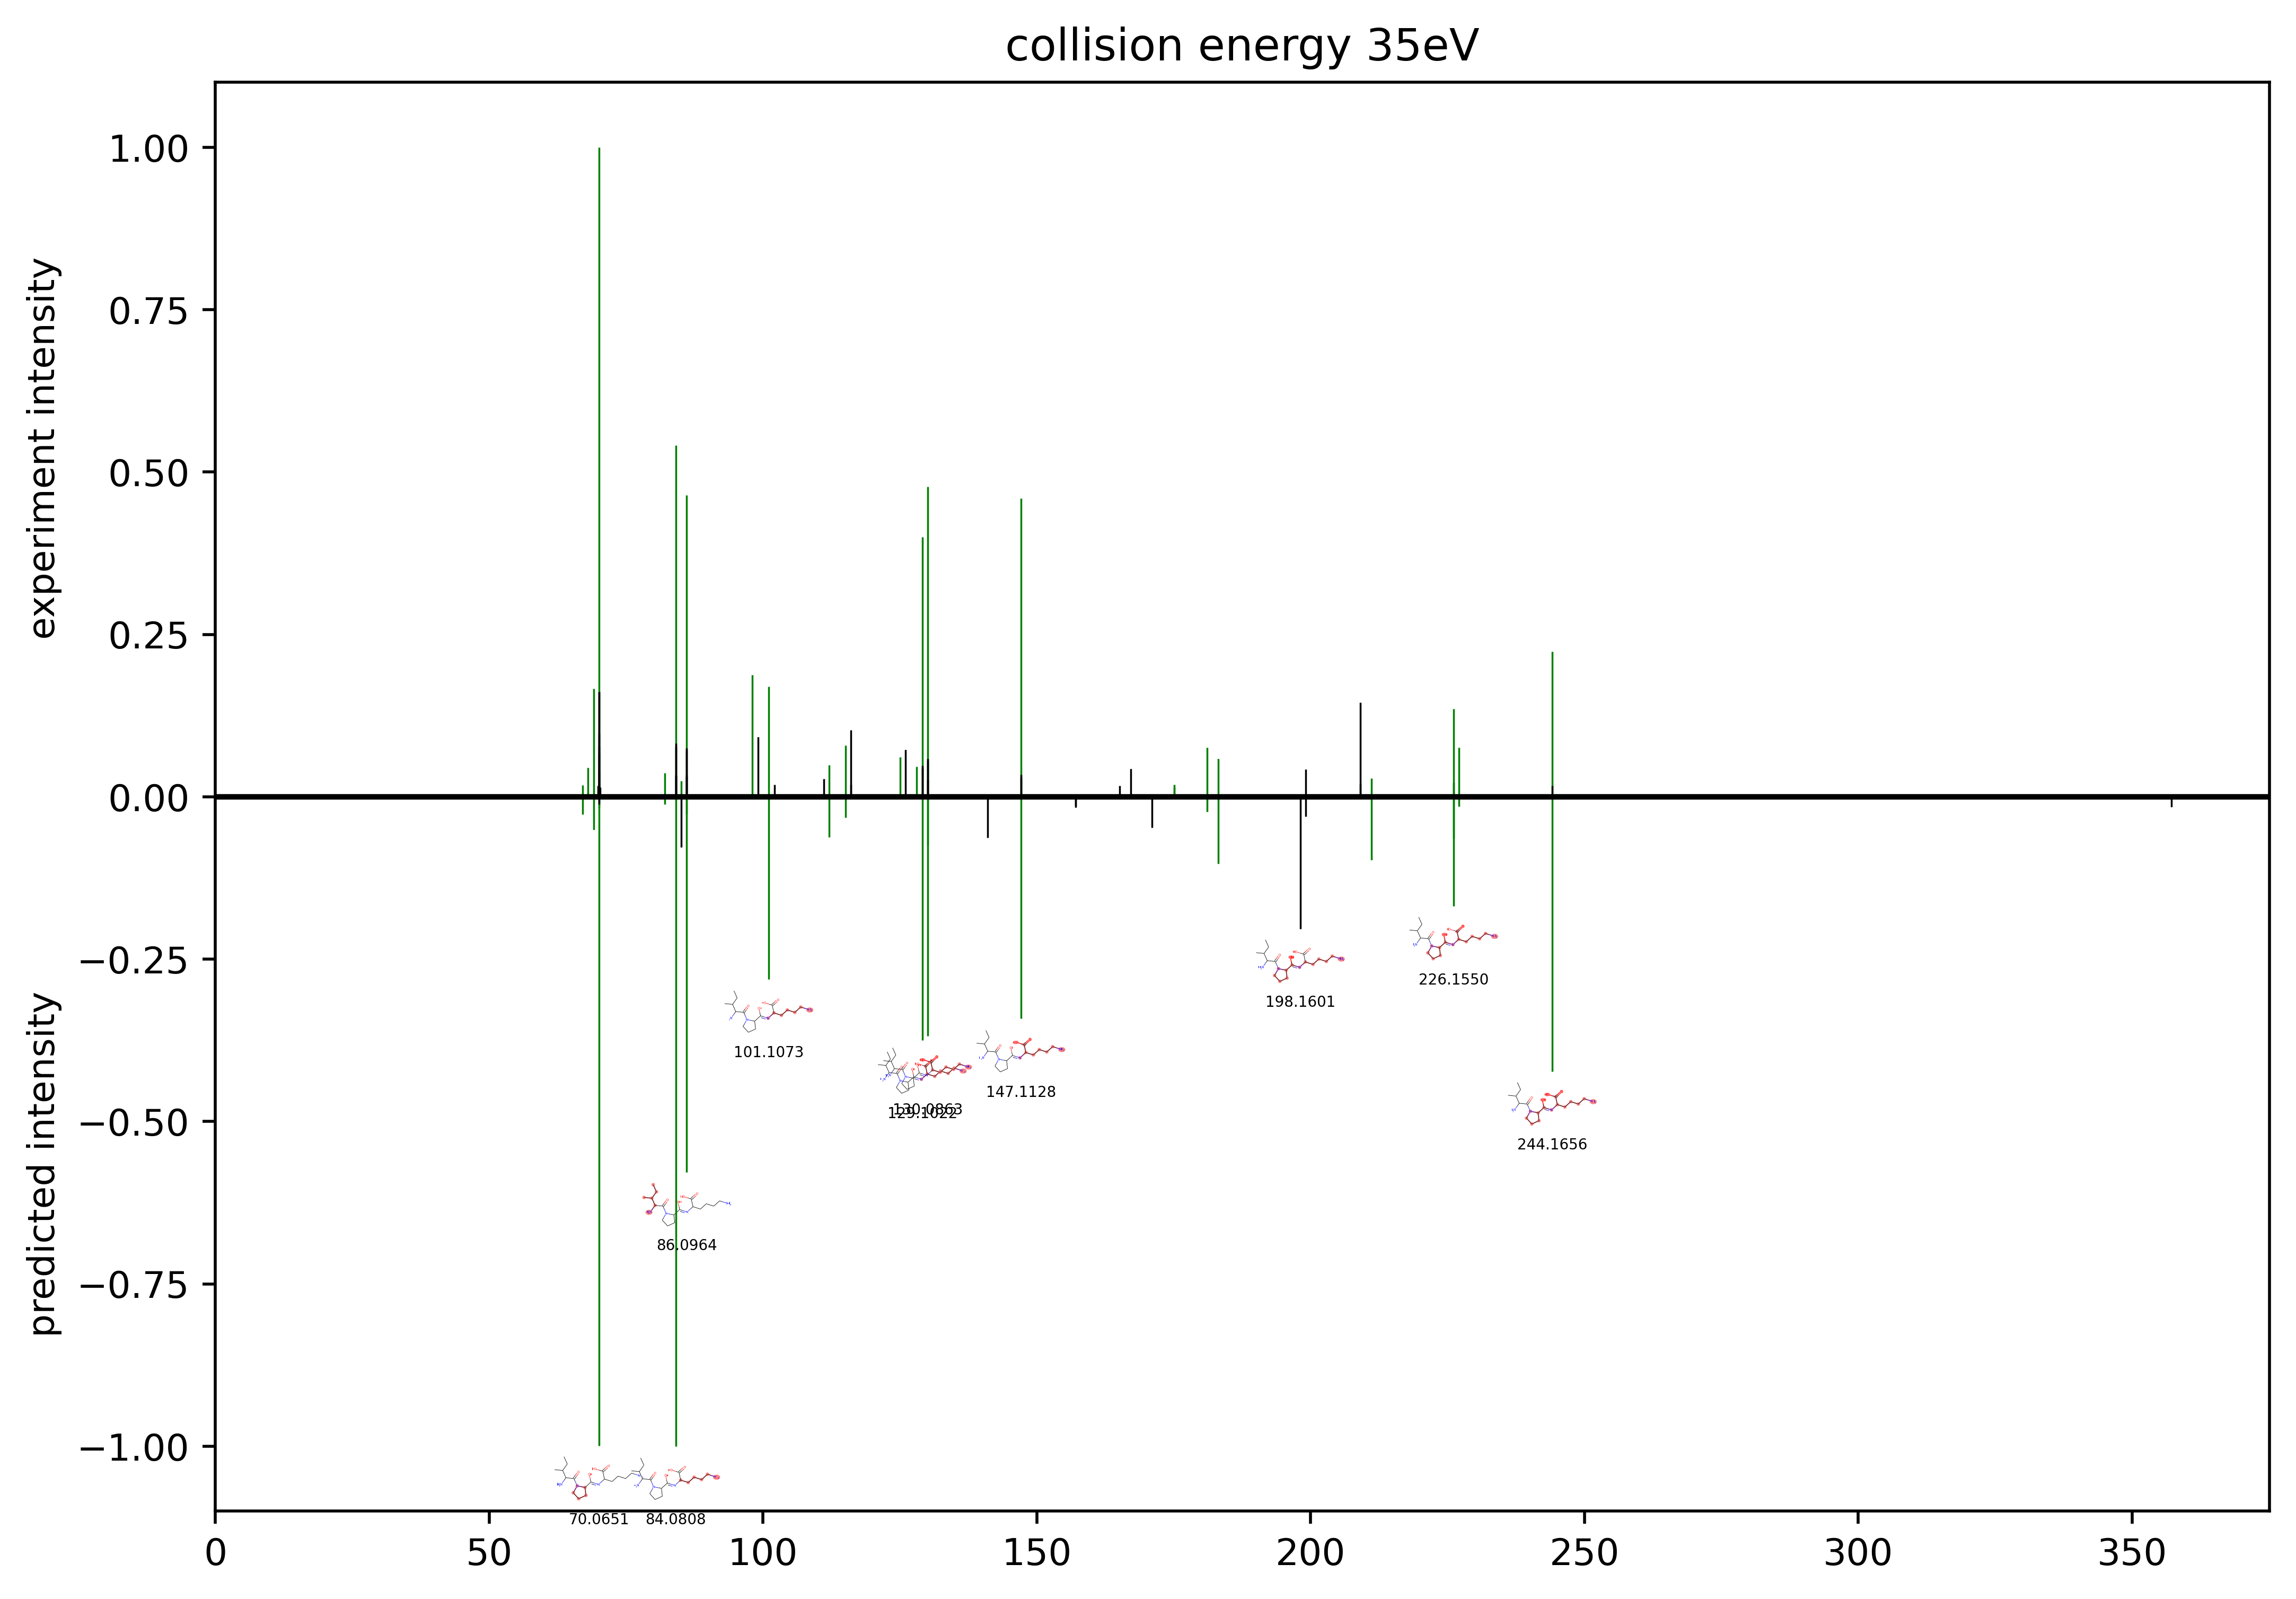

In [22]:
broad_elucidation('mxp4042', 'C17H32N4O4', r'CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)O)N', 'Ile-Pro-Lys', True)

[Unknown-Lys-Leu-Pro] Found target mol at 1/347, ent_dist=0.572


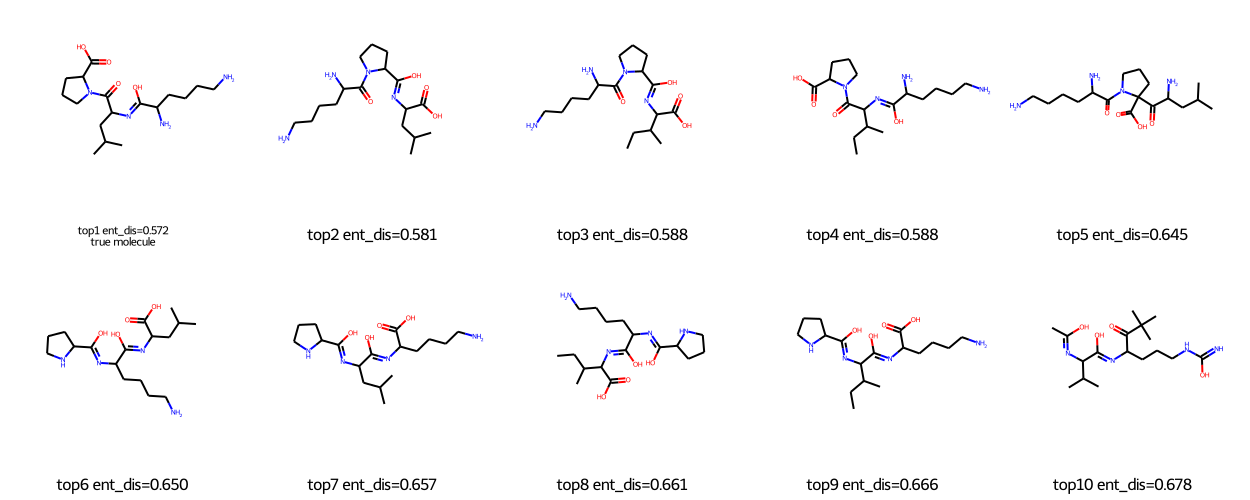

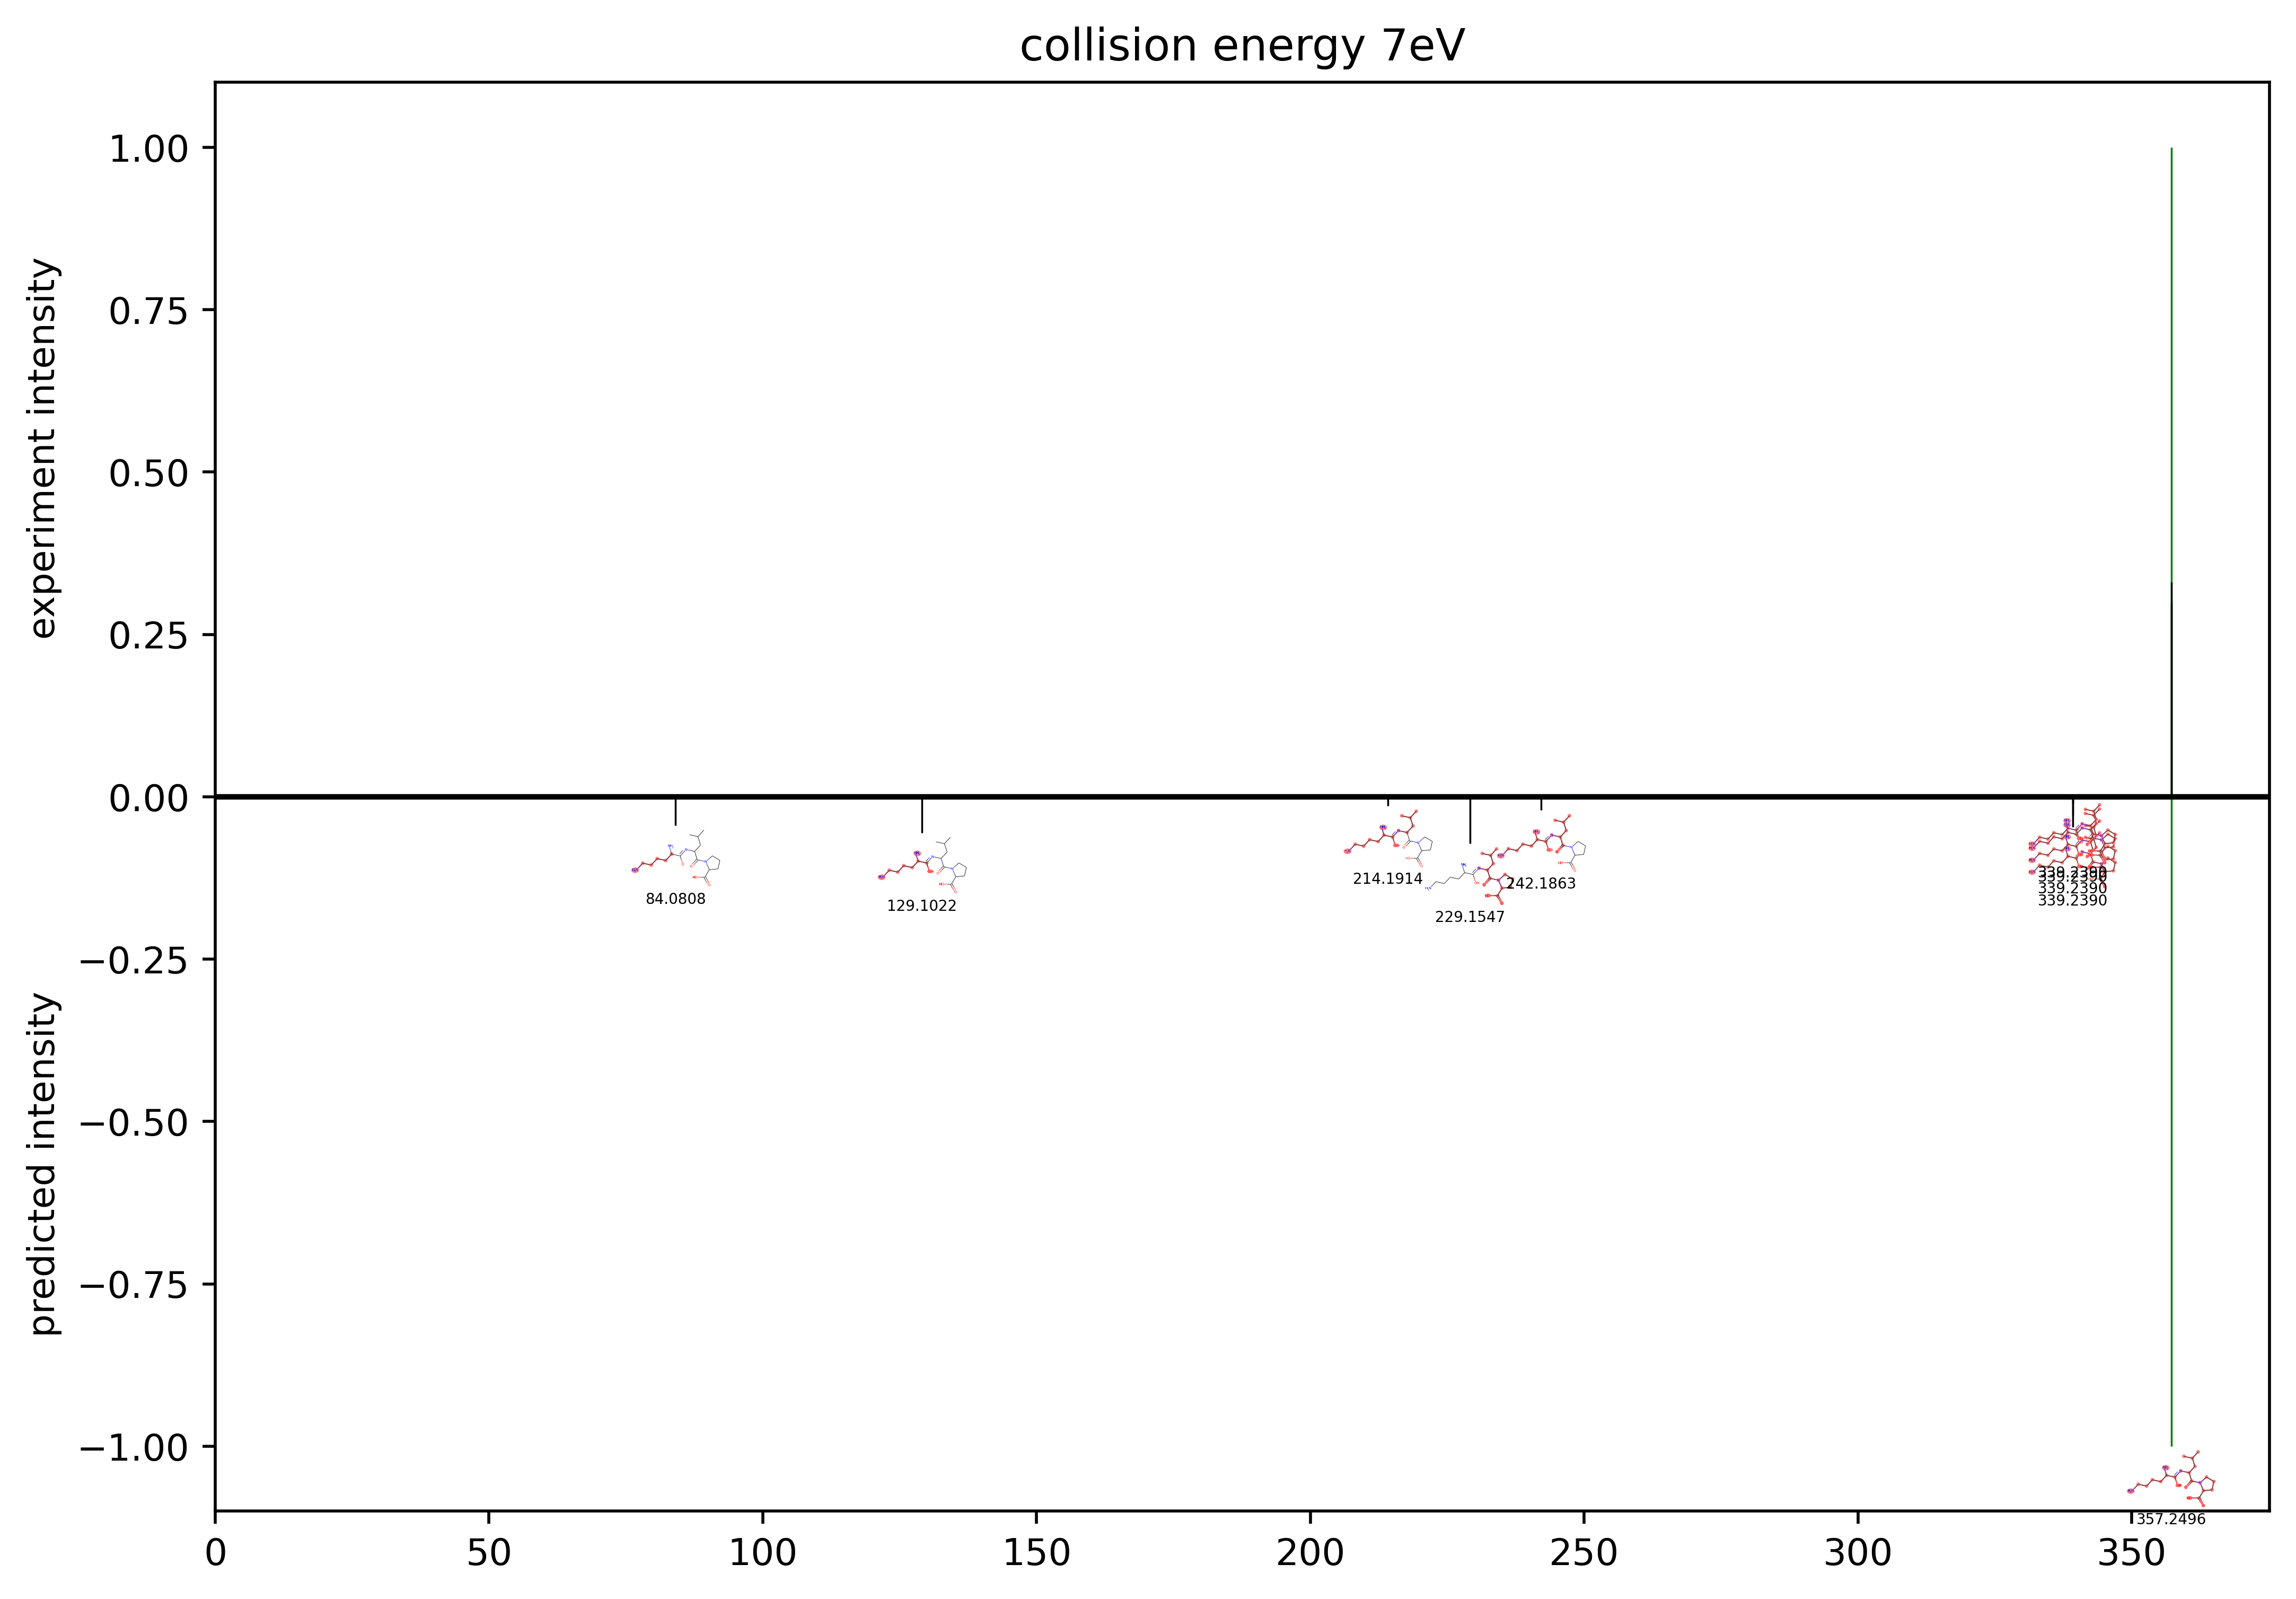

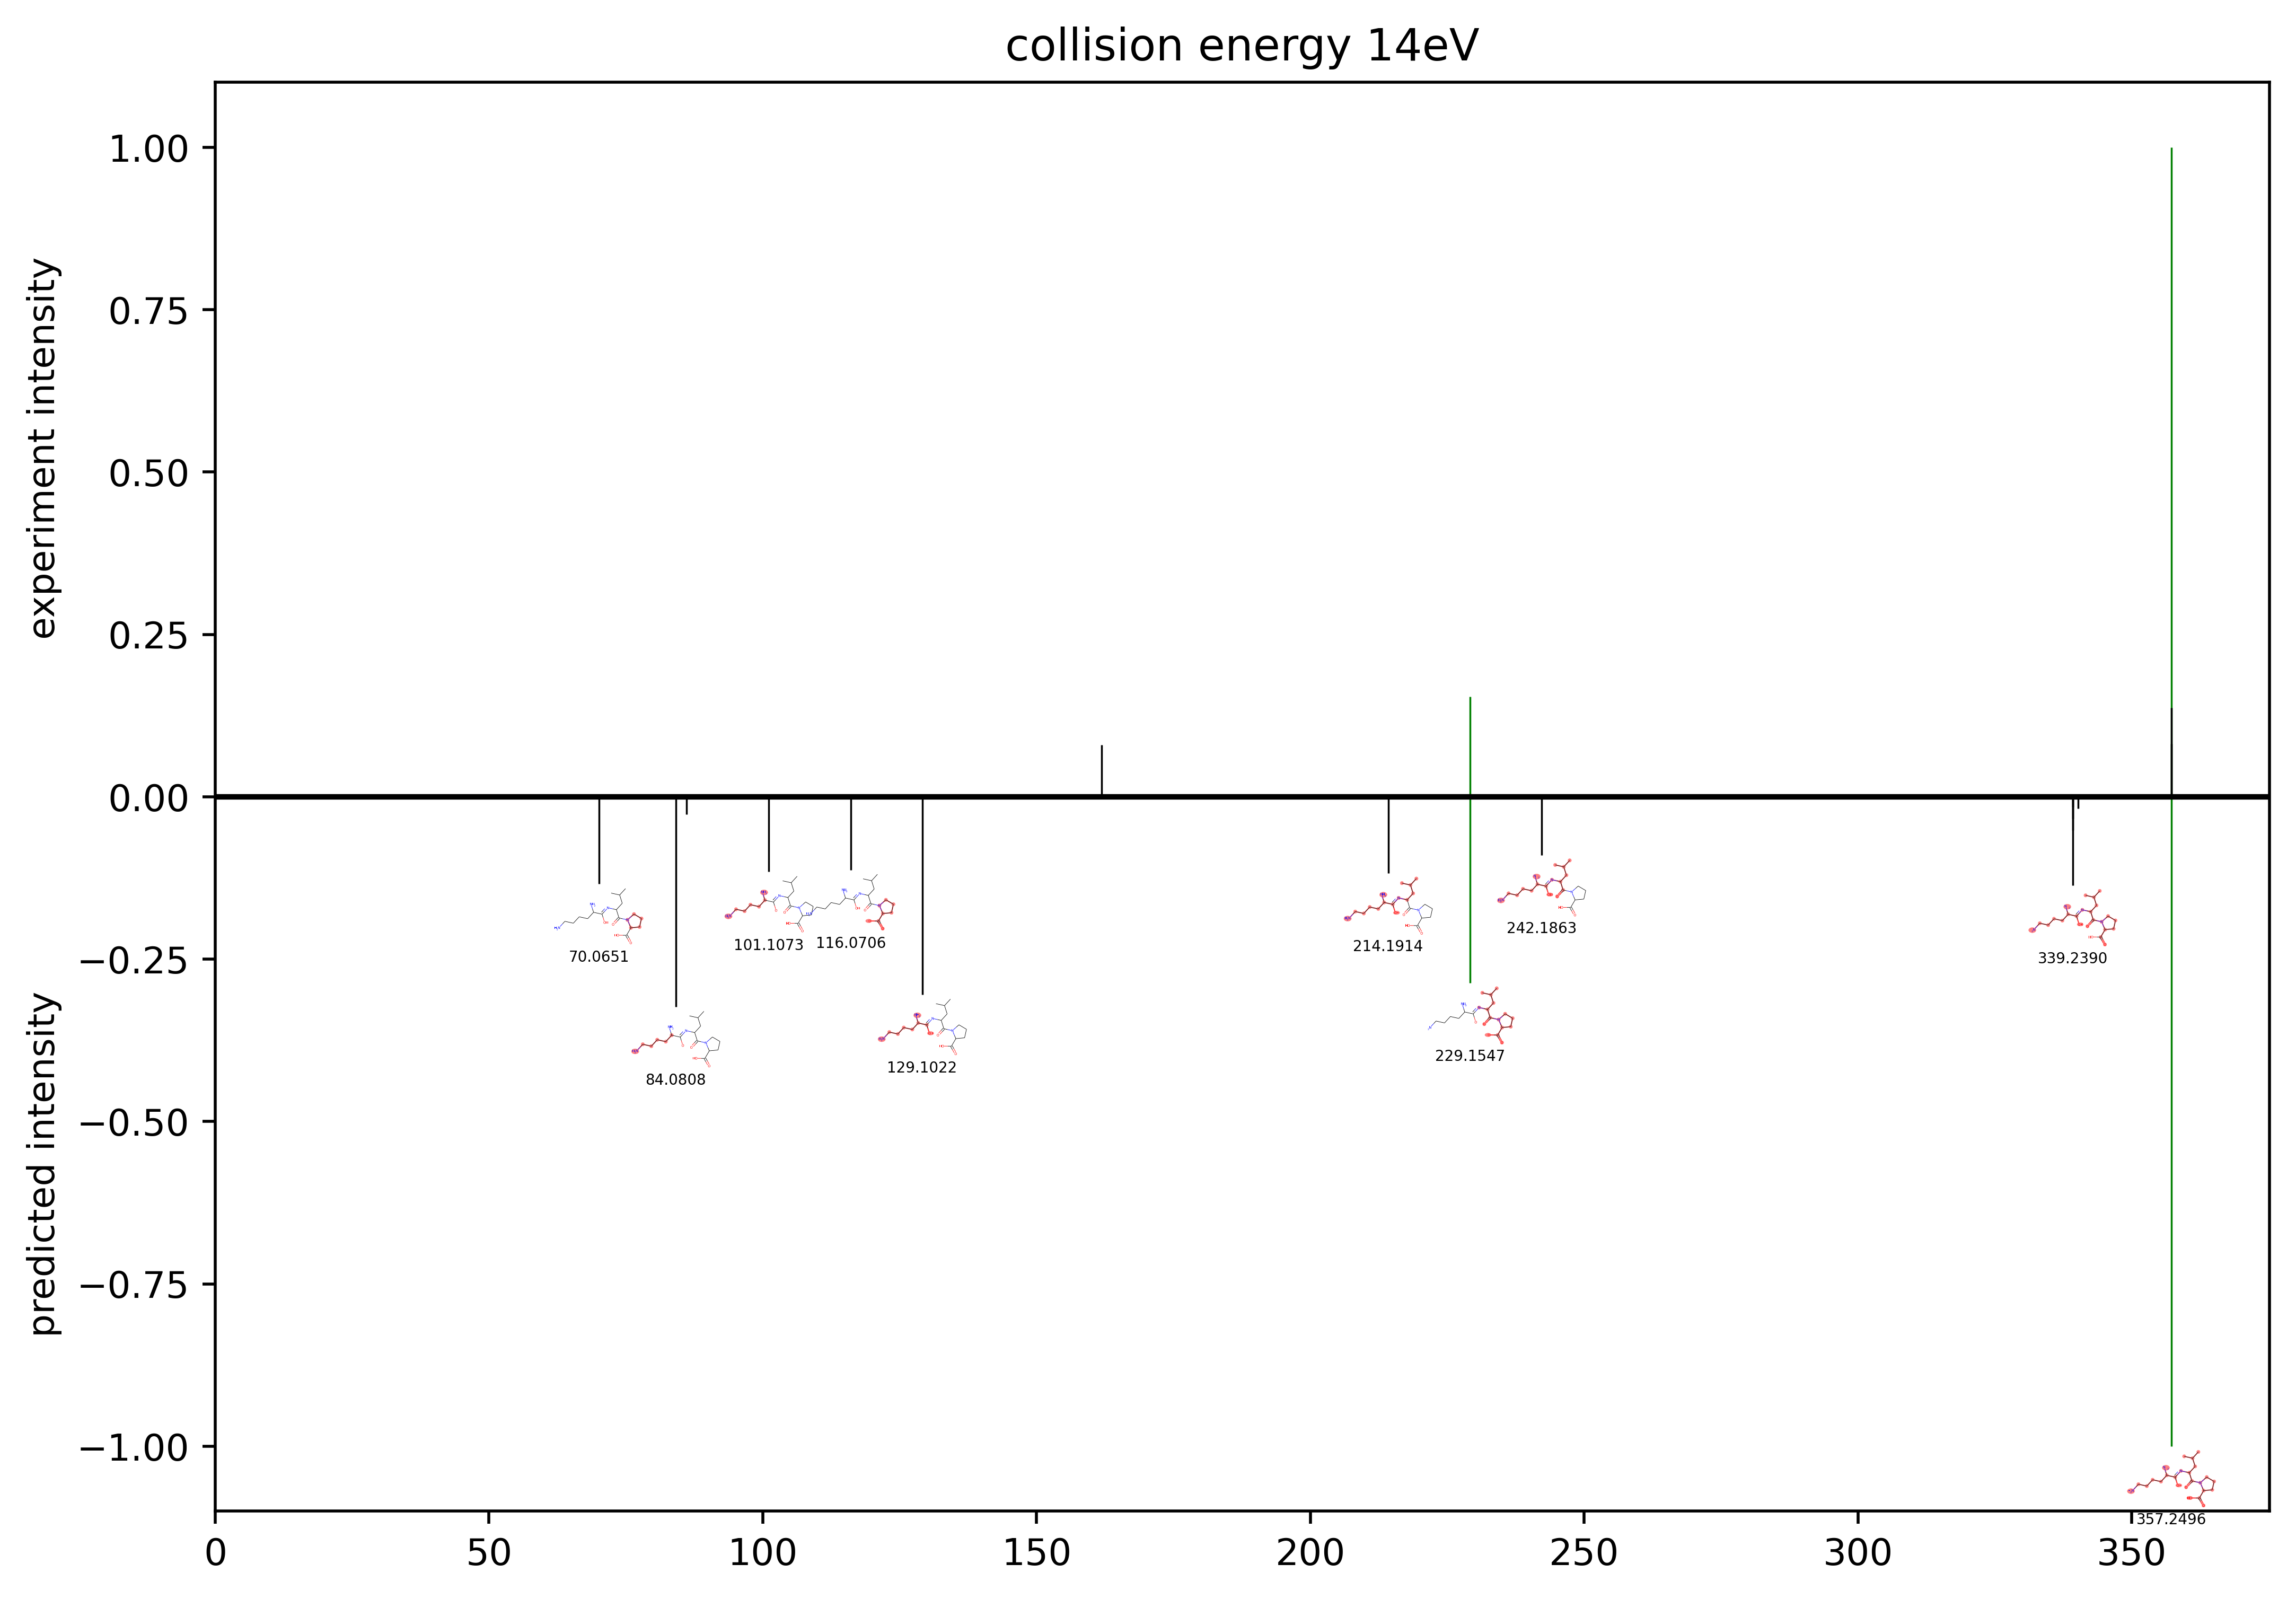

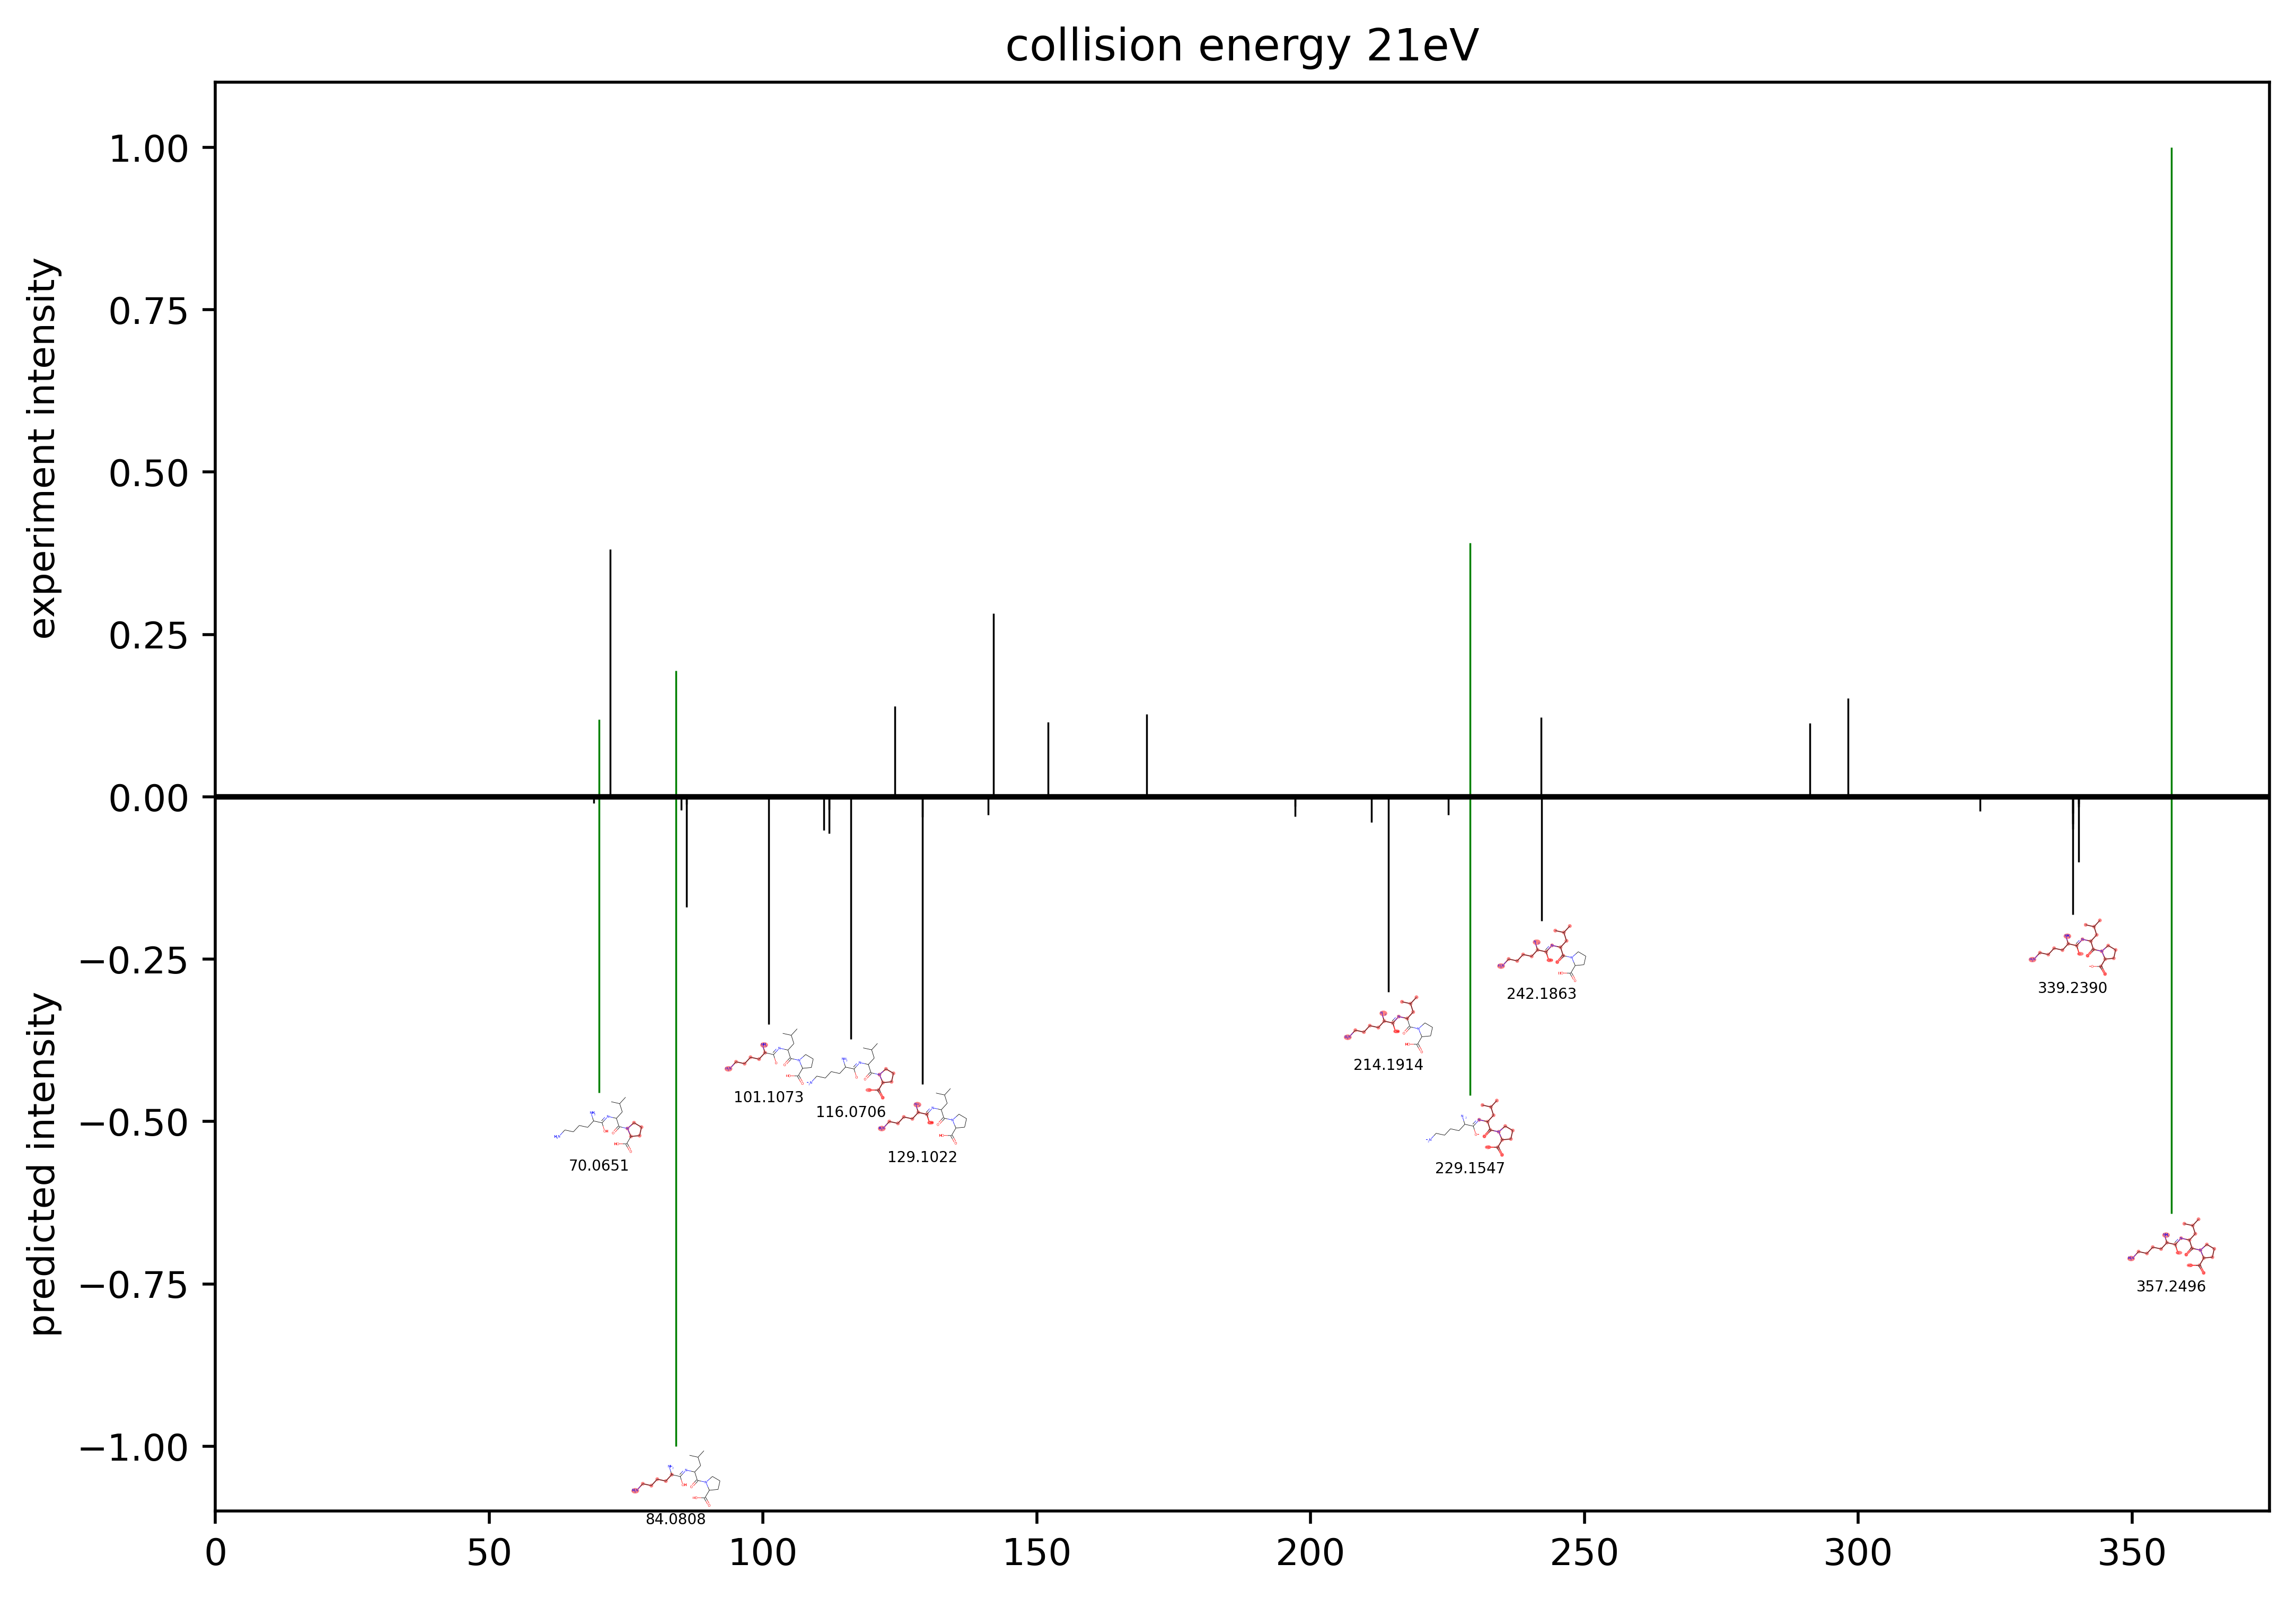

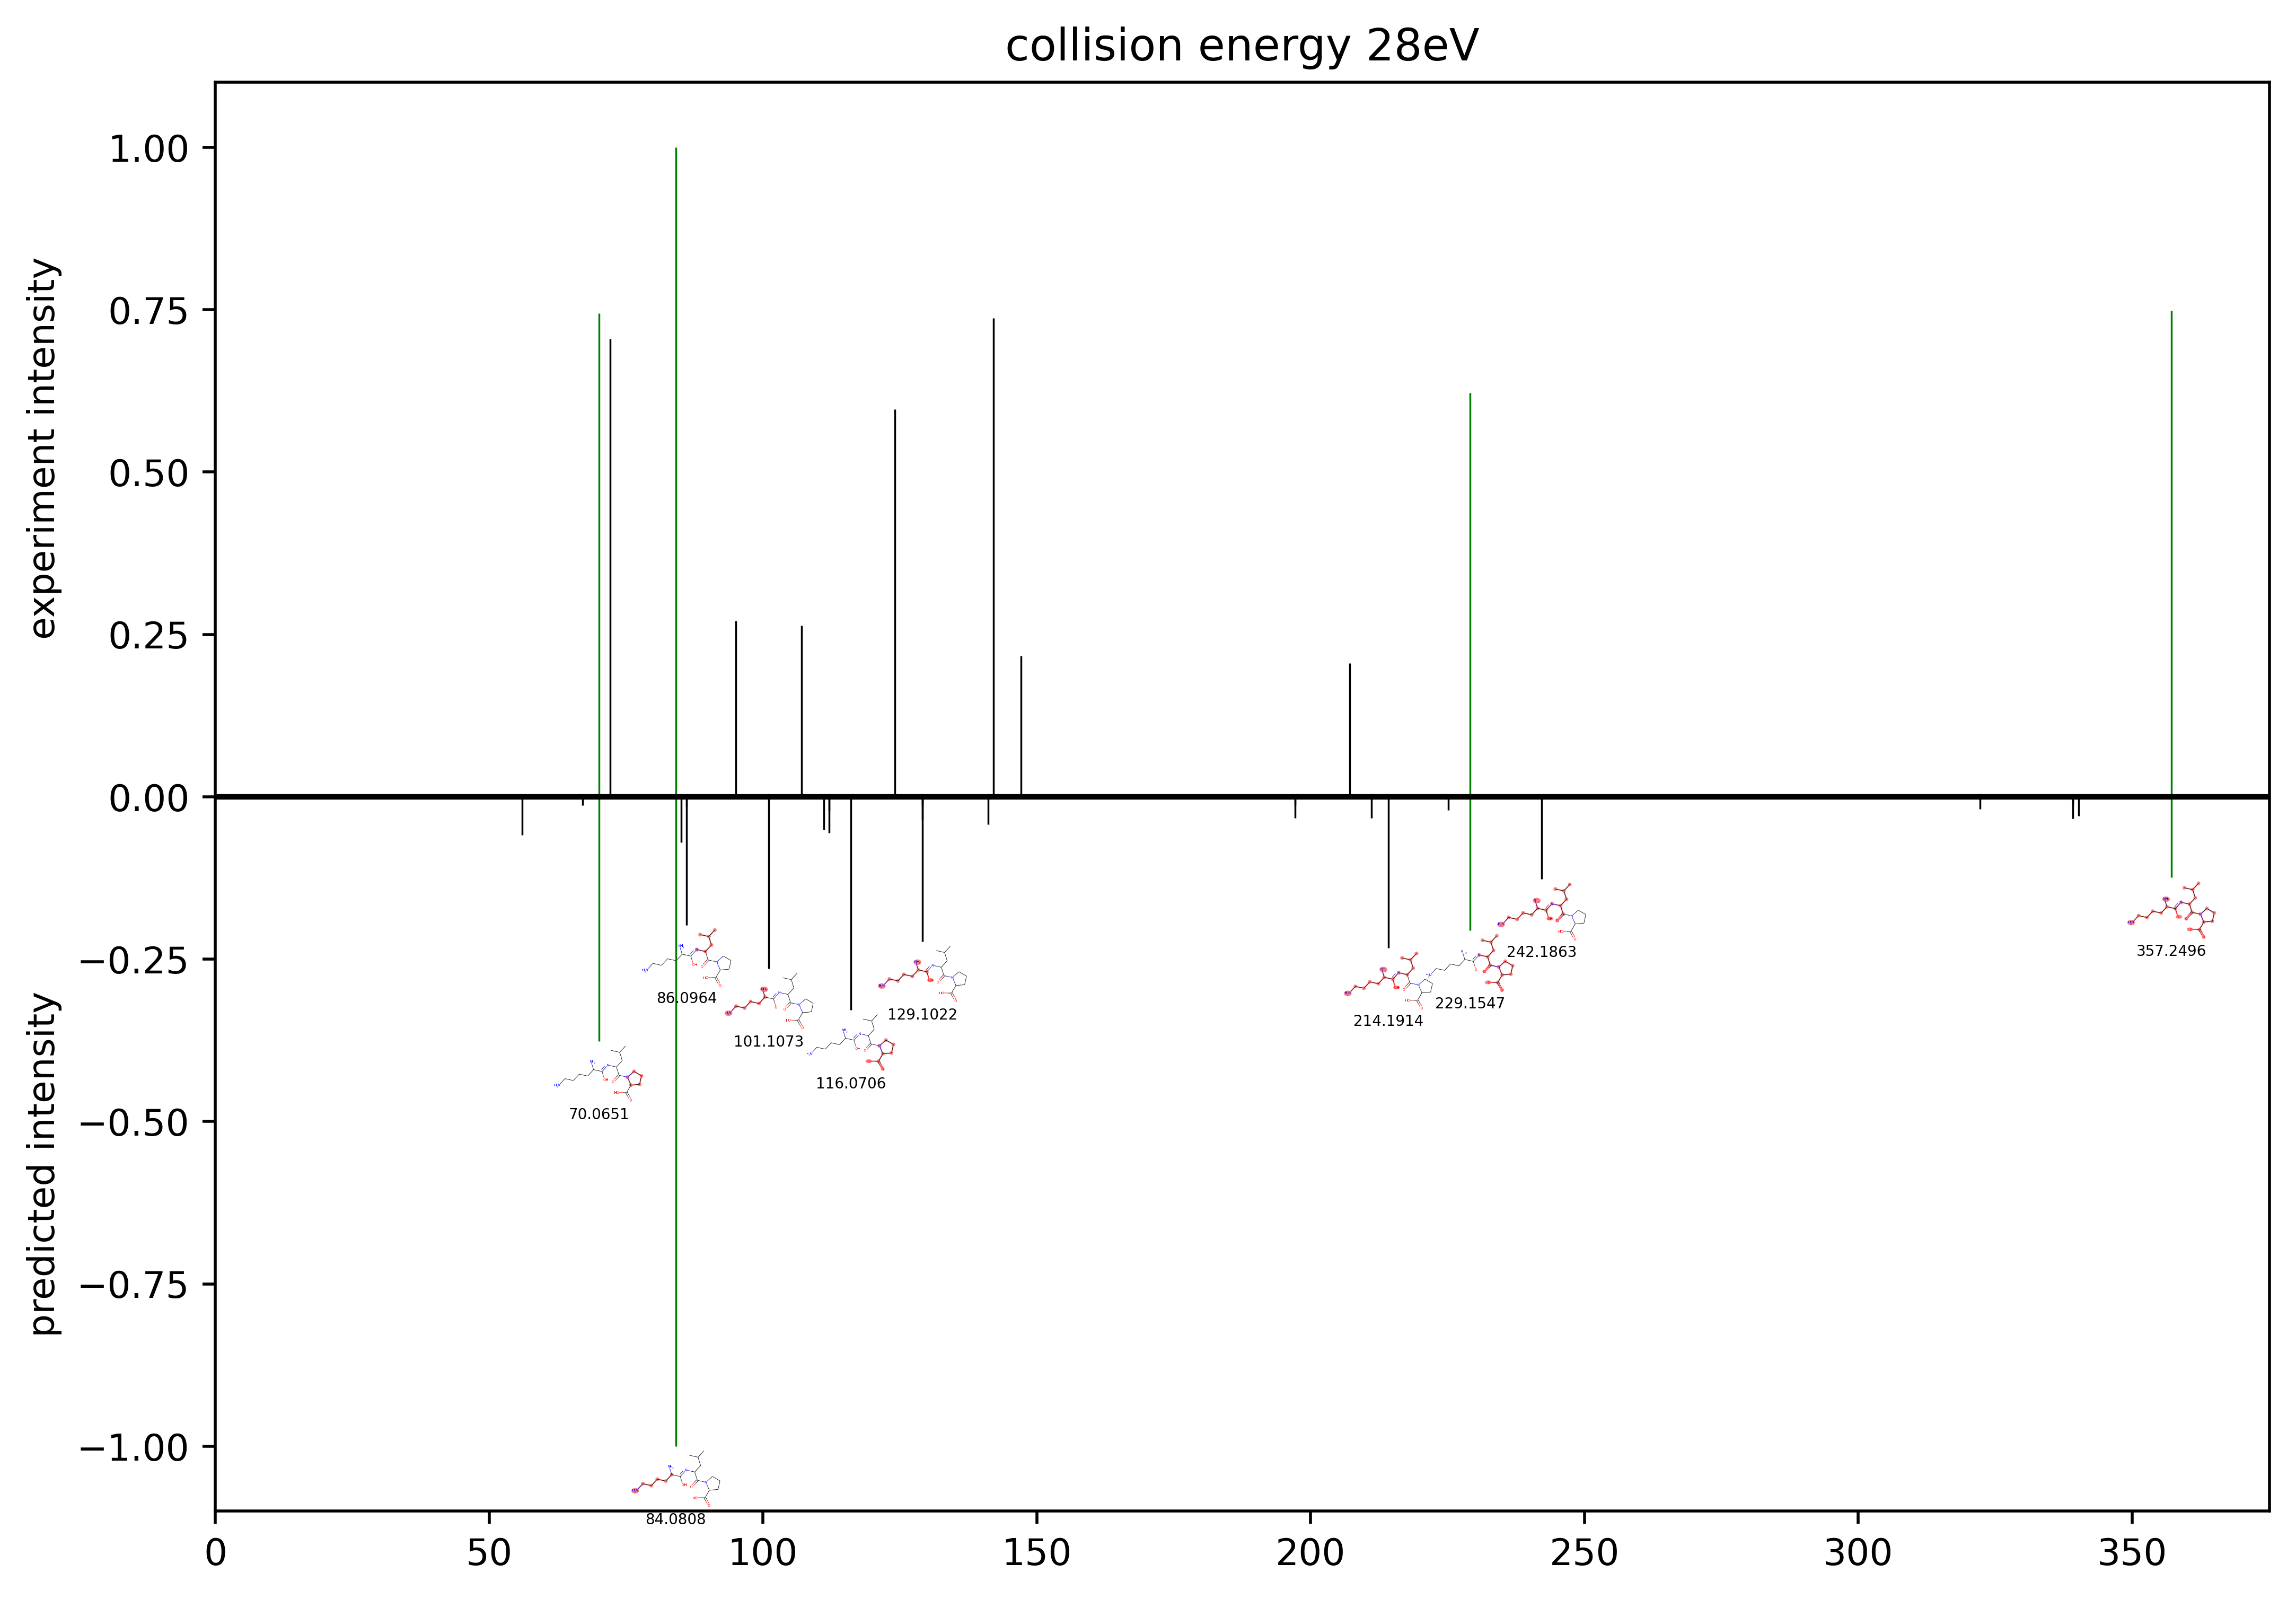

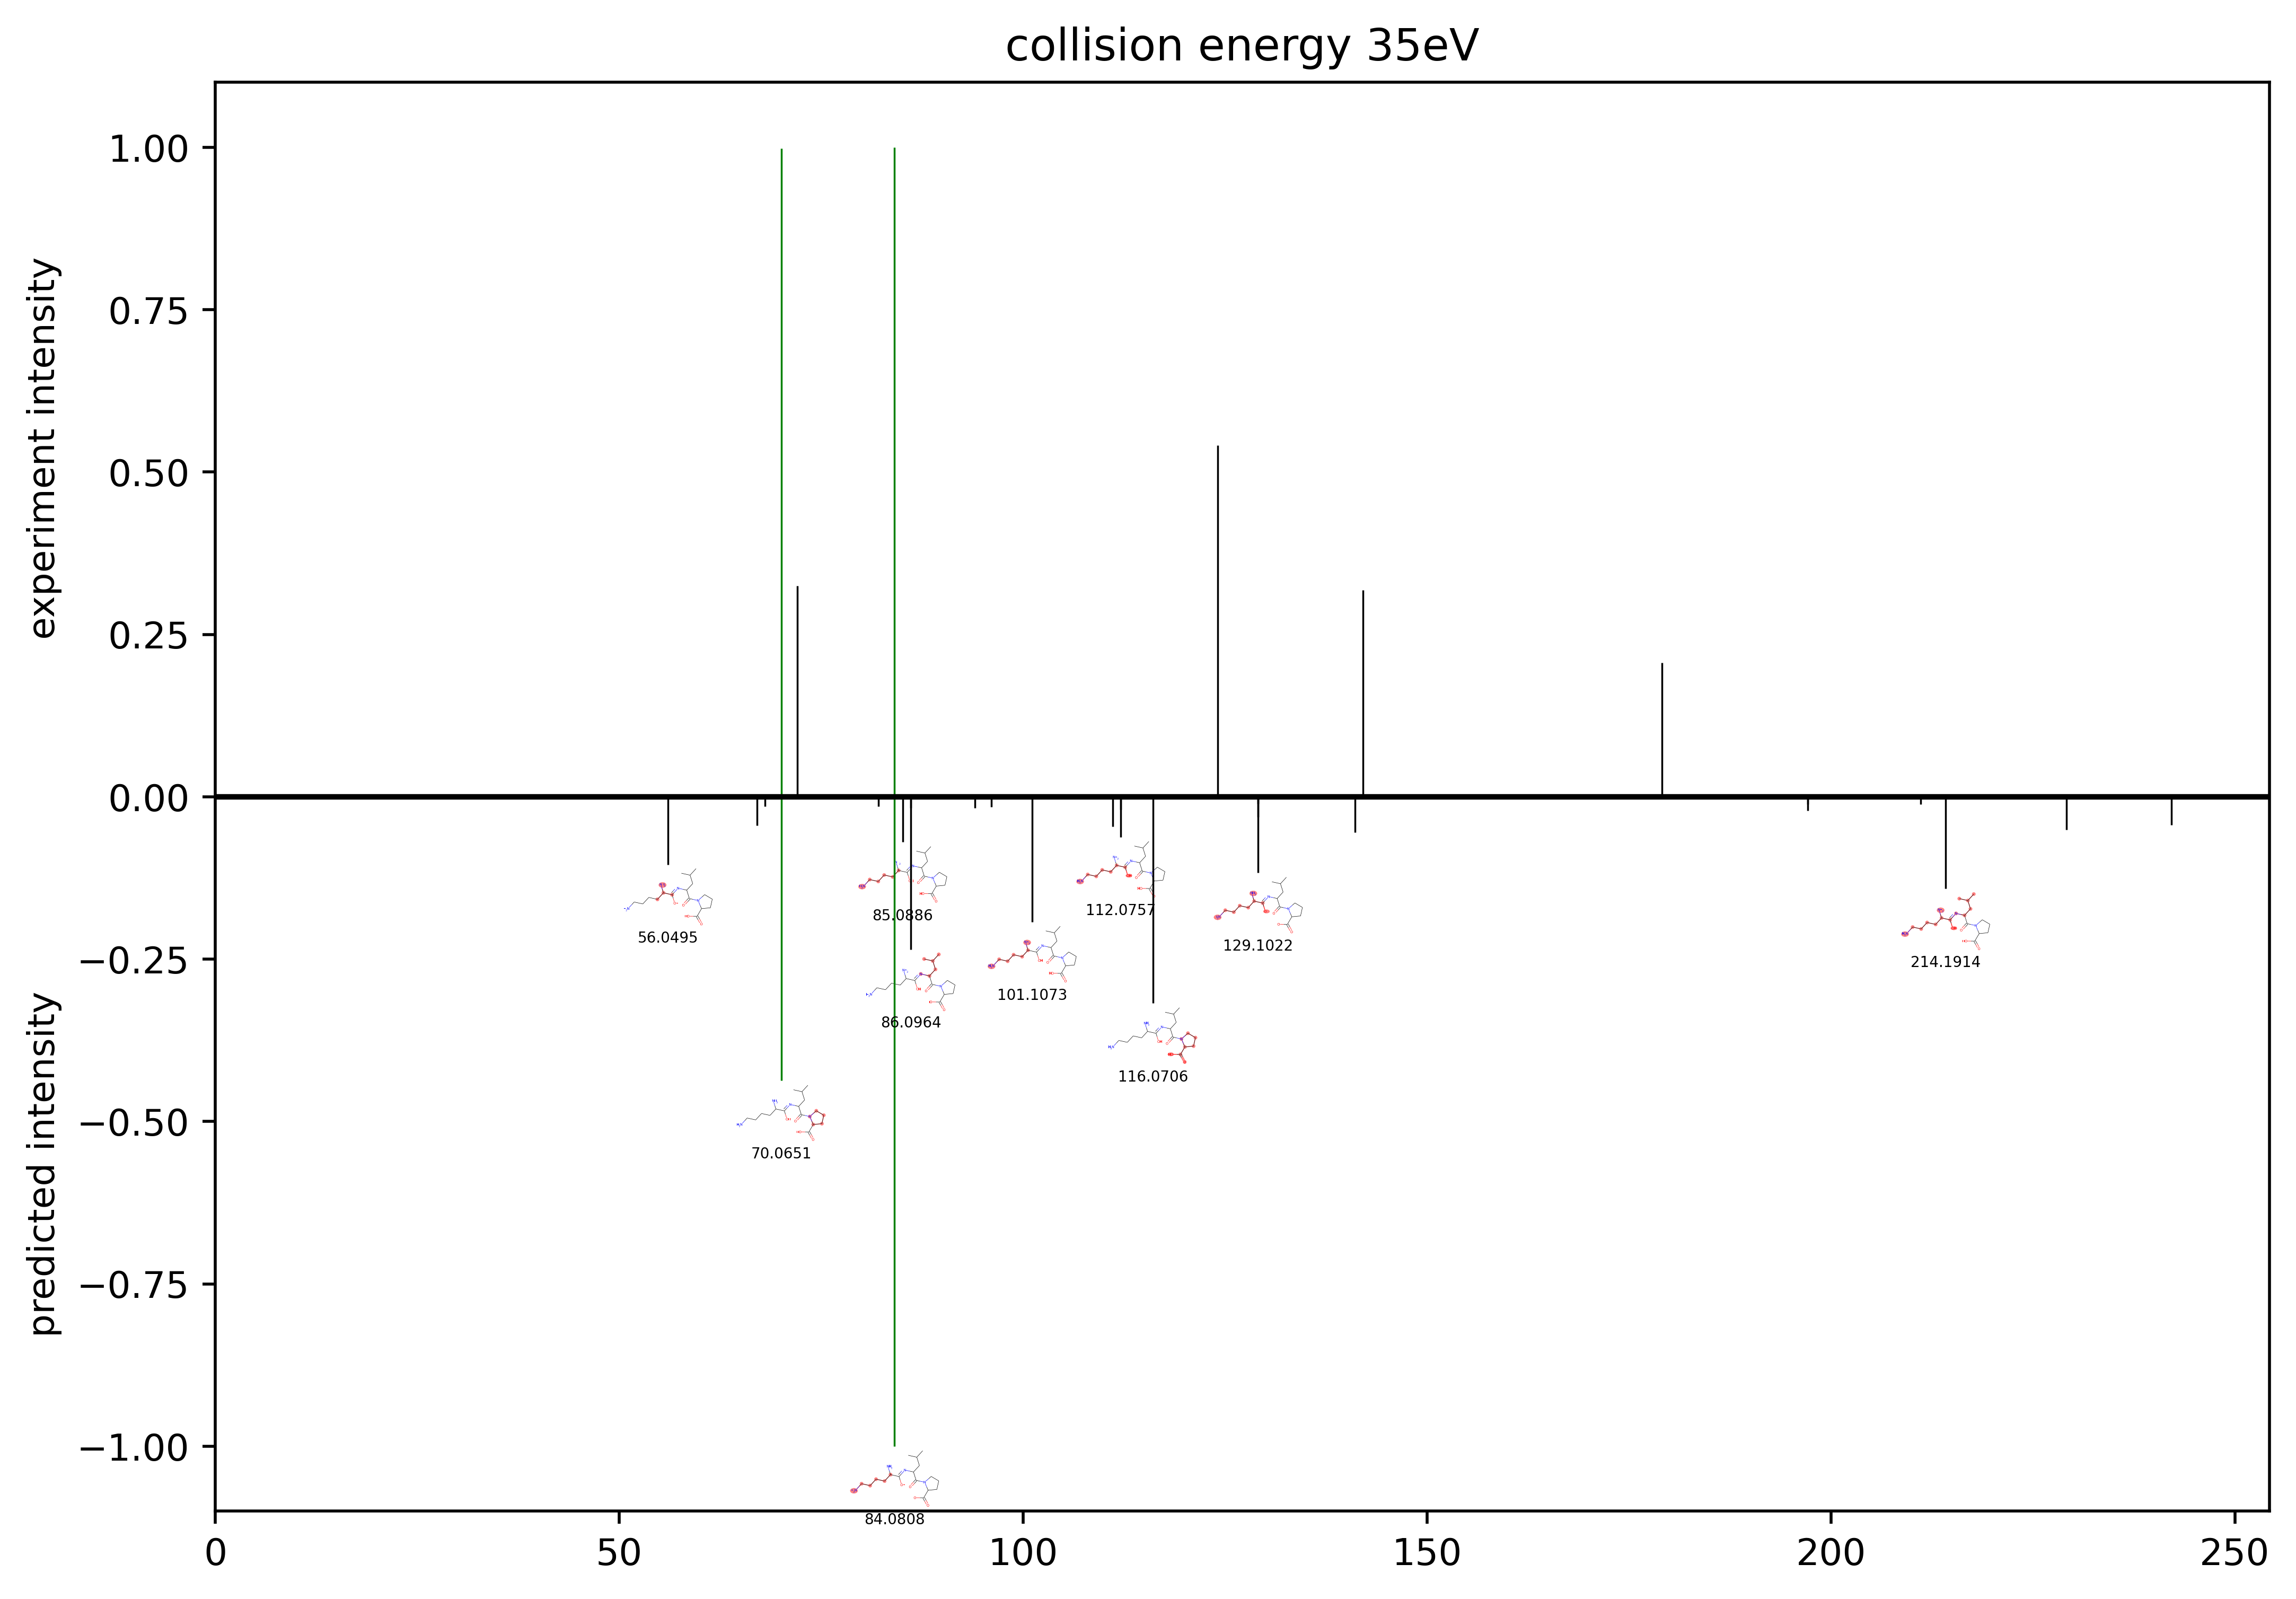

In [21]:
broad_elucidation('QI8422', 'C17H32N4O4', 'CC(C)CC(C(=O)N1CCCC1C(=O)O)NC(=O)C(CCCCN)N', 'Unknown-Lys-Leu-Pro', True)

## Food biomarkers

In [ ]:
broad_config = copy.deepcopy(config)
broad_config['nce'] = True # use nce for collision energy

# Get candidates
df = pd.read_csv('/home/roger/ms_collaborators/broad-Julian/24_0723_Compounds_to_generate_in_silico_MSMS.csv')
out_dir = Path('/home/roger/ms_collaborators/broad-Julian/foodbiomarker')
out_dir.mkdir(parents=True, exist_ok=True)

# fix formula mismatch
for idx, row in df.iterrows():
    df.at[idx, 'Chemical Formula'] = common.form_from_smi(row['SMILES'])

smiles = []
for idx, row in df.iterrows():
    smiles.append(common.rm_stereo(row['SMILES']))

result_path, pmz = iceberg_prediction(smiles, [10, 20, 30, 40, 50], **broad_config)

smiles, pred_specs, pred_frags = load_pred_spec(result_path, False)
for smi, pred_spec in zip(smiles, pred_specs):
    inchikey = common.inchikey_from_smiles(smi)
    out_arr = np.zeros((0, 3))
    for ev, spec in pred_spec.items():
        spec[:, 1] *= 100
        out_arr = np.concatenate(
            (out_arr,
             np.concatenate((spec, np.ones((spec.shape[0], 1)) * float(ev)), axis=-1)),
            axis=0
        )
    df = pd.DataFrame(data=out_arr, columns=['m/z', 'inten', 'ev'])
    df.to_csv(out_dir / f'{inchikey}.csv', index=False)
